In [1]:
import numpy as np
import pandas as pd
import os

##import tensorflow as tf
from tensorflow.keras import Model,regularizers
from tensorflow.keras.layers import Input,Dense,Bidirectional,LSTM,RepeatVector,TimeDistributed
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from numpy import array, hstack

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from lib.feature_generator import FeatureGenerator

In [2]:
##feature_generator=FeatureGenerator(lag_window=4,rolmean_window=4,rolstd_window=4)
feature_generator=FeatureGenerator(lag_window=4,rolmean_window=4)
input_time_window = 9;output_time_window = 3;test_batch = 1
result_lst = []

initialize feature generator


In [3]:
def minmax_scale(X):
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    X_scaled = (X - min_val) / (max_val - min_val)
    return X_scaled, min_val, max_val

def minmax_inverse_scale_target(y_scaled, min_val, max_val, target_index):
    y_inversed = y_scaled * (max_val[target_index] - min_val[target_index]) + min_val[target_index]
    return y_inversed

def create_sequences(input_data, input_features , input_tw , output_tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-input_tw):
        train_seq = input_data[i:i+input_tw,:input_features]
        train_label = input_data[i+input_tw:i+input_tw+output_tw, input_features] # predict the 'BillingPaymentNo' feature
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def build_model(input_timesteps,input_features,output_timesteps,output_features):
    #define input data shape .here our input timesteps=9 and input_features=10.
    encoder_inputs = Input(shape=(input_timesteps,input_features))
    #use single BiLstm as encoder
    #Here we can use bigger network also like one BiLSTM with return_sequences=True and 
    # other BiLSTM with return_sequences=False
    # Or CNN,CNN+LSTM etc 
    encoder = Bidirectional(LSTM(units=32 ,return_sequences=False,dropout=0.2,recurrent_dropout=0.2,
                                kernel_regularizer=regularizers.l2(0.001)))(encoder_inputs)
    
    #Apply RepeatVector to get the result for multiple time steps . Here our output timesteps is 3
    # and output features is 1
    #Decoder operation 
    repeat_output = RepeatVector(output_timesteps)(encoder)
    decoder = Bidirectional(LSTM(units=32,return_sequences=True,dropout=0.2,recurrent_dropout=0.2,
                                kernel_regularizer=regularizers.l2(0.001)))(repeat_output)  
    
    #Use time distributed layer to get multiple output features
    out = TimeDistributed(Dense(output_features))(decoder)
    model = Model(encoder_inputs,out)
    #Compile the model
    
    return model

def display_plots(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'],loc = 'upper right')
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'],loc = 'upper right')
    plt.show()

In [4]:
parent_dir_path = os.path.dirname(os.getcwd())
raw_data_path = os.path.join(parent_dir_path,'data'+ os.path.sep +'raw'+os.path.sep)
segment_data_path =  os.path.join(parent_dir_path,'data'+ os.path.sep +'segments'+os.path.sep)
feature_data_path = os.path.join(parent_dir_path,'data'+ os.path.sep +'features'+os.path.sep)
models_path =  os.path.join(parent_dir_path,'models'+os.path.sep+'seq2seqbiLSTM'+os.path.sep)
logs_path = os.path.join(parent_dir_path,'logs'+os.path.sep+'tensorboard'+os.path.sep)
stats_path = os.path.join(parent_dir_path,'logs'+os.path.sep+'records'+os.path.sep)

In [5]:
crma_details = pd.read_excel(raw_data_path + 'CRMAccountDetails.xlsx')
selected_regions = ['Great Lakes','South','West','Northeast']
selected_programsTypes = ['ADN','PN','BSN','Diploma']
crma_details = crma_details[crma_details['ProgramType'].isin(selected_programsTypes)]
crma_details = crma_details[crma_details['Region'].isin(selected_regions)]
Teas_reg_data = pd.read_excel(raw_data_path + 'TEAS Registrations.xlsx')
payment_df = pd.ExcelFile(raw_data_path + 'First Payments Existing Customers.xlsx')
all_paymnt_df = pd.read_excel(payment_df, 'All Pmt Plans')
multi_pmt_plan_df = pd.read_excel(payment_df, 'Multi Pmt Plans Only')
Teas_test_data = pd.read_excel(raw_data_path +'TEASTestDetails.xlsx')

In [6]:
crma_grp = crma_details.groupby(['InstitutionTypeName','SchoolType','ProgramType','Region'])['InstitutionID'].apply(list).reset_index()
teas_reg_grp = Teas_reg_data.groupby(['Year','Quarter'])['#UsersRegistered'].sum().reset_index()
teas_test_df = Teas_test_data[Teas_test_data['Year'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
teas_test_df_grp = teas_test_df.groupby(['Year', 'Quarter']).sum().reset_index()

C:\work\Ascend\ATI_Student_Billing_pred\source_DL\source\lib\feature_generator.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'#TEASexamsAttempt{j}Advanced_rolling_std_{i}']= df[f'#TEASexamsAttempt{j}Advanced'].rolling(window=i).std()
C:\work\Ascend\ATI_Student_Billing_pred\source_DL\source\lib\feature_generator.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'#TEASexamsAttempt{j}Exemplary_rolling_std_{i}'] = df[f'#TEASexamsAttempt{j}Exemplary'].rolling(window=i).std()
C:\work\Ascend\ATI_Student_Billing_pred

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 64)            24832     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 3, 1)             65        
 ibuted)                                                     

12/12 [==============================] - 0s 17ms/step - loss: 0.0366 - mse: 0.0283 - val_loss: 0.0413 - val_mse: 0.0329
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0329 - mse: 0.0246 - val_loss: 0.0675 - val_mse: 0.0593
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0307 - mse: 0.0227 - val_loss: 0.0516 - val_mse: 0.0440
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0355 - mse: 0.0273 - val_loss: 0.0861 - val_mse: 0.0773
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0412 - mse: 0.0324 - val_loss: 0.0502 - val_mse: 0.0411
Epoch 57/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0331 - mse: 0.0238 - val_loss: 0.1413 - val_mse: 0.1312
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0639 - mse: 0.0524 - val_loss: 0.0789 - val_mse: 0.0648
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0594 

12/12 [==============================] - 0s 17ms/step - loss: 0.0471 - mse: 0.0226 - val_loss: 0.0519 - val_mse: 0.0297
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0364 - mse: 0.0159 - val_loss: 0.0640 - val_mse: 0.0454
Epoch 115/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0391 - mse: 0.0220 - val_loss: 0.0382 - val_mse: 0.0224
Epoch 116/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0291 - mse: 0.0145 - val_loss: 0.0491 - val_mse: 0.0358
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0407 - mse: 0.0281 - val_loss: 0.0497 - val_mse: 0.0363
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0377 - mse: 0.0226 - val_loss: 0.0926 - val_mse: 0.0765
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0384 - mse: 0.0229 - val_loss: 0.0507 - val_mse: 0.0356
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0309 - mse: 0.0186 - val_loss: 0.0432 - val_mse: 0.0317
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0239 - mse: 0.0130 - val_loss: 0.0516 - val_mse: 0.0414
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0229 - mse: 0.0132 - val_loss: 0.0362 - val_mse: 0.0271
Epoch 177/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0239 - mse: 0.0152 - val_loss: 0.0579 - val_mse: 0.0497
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0305 - mse: 0.0225 - val_loss: 0.0361 - val_mse: 0.0284
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0234 - mse: 0.0156 - val_loss: 0.0476 - val_mse: 0.0398
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0237 - mse: 0.0161 - val_loss: 0.0424 - val_mse: 0.0352
Epoch 181/200
12/12 [==============================] - 0s 14ms/step - loss: 

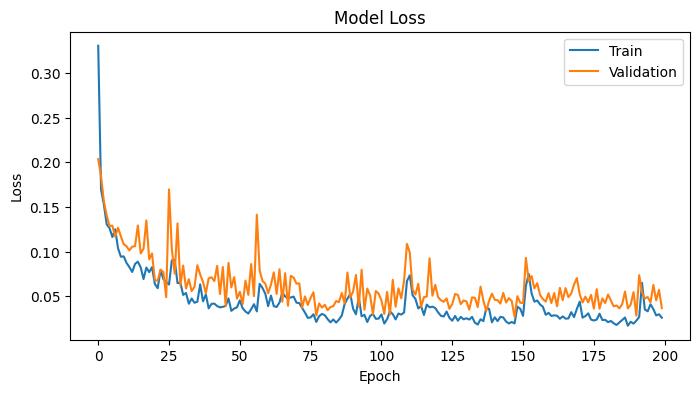

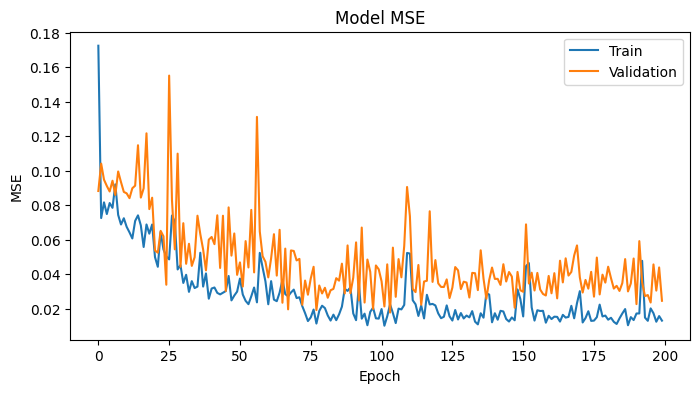

1/1 [==============================] - 1s 813ms/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               11008     
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 64)            24832     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 16ms/step - loss: 0.0591 - mse: 0.0502 - val_loss: 0.0637 - val_mse: 0.0550
Epoch 53/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0552 - mse: 0.0467 - val_loss: 0.0629 - val_mse: 0.0545
Epoch 54/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0558 - mse: 0.0473 - val_loss: 0.0910 - val_mse: 0.0823
Epoch 55/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0659 - mse: 0.0568 - val_loss: 0.0605 - val_mse: 0.0508
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0633 - mse: 0.0531 - val_loss: 0.0608 - val_mse: 0.0507
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0747 - mse: 0.0644 - val_loss: 0.0624 - val_mse: 0.0514
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0845 - mse: 0.0734 - val_loss: 0.0636 - val_mse: 0.0528
Epoch 59/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0655 

12/12 [==============================] - 0s 16ms/step - loss: 0.0438 - mse: 0.0315 - val_loss: 0.0623 - val_mse: 0.0503
Epoch 114/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0469 - mse: 0.0352 - val_loss: 0.0669 - val_mse: 0.0556
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0454 - mse: 0.0339 - val_loss: 0.0621 - val_mse: 0.0504
Epoch 116/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0555 - mse: 0.0440 - val_loss: 0.0651 - val_mse: 0.0538
Epoch 117/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0429 - mse: 0.0314 - val_loss: 0.0623 - val_mse: 0.0508
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0531 - mse: 0.0417 - val_loss: 0.0653 - val_mse: 0.0537
Epoch 119/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0437 - mse: 0.0323 - val_loss: 0.0661 - val_mse: 0.0550
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 14ms/step - loss: 0.0449 - mse: 0.0260 - val_loss: 0.0841 - val_mse: 0.0659
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0494 - mse: 0.0320 - val_loss: 0.0735 - val_mse: 0.0570
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0419 - mse: 0.0254 - val_loss: 0.0743 - val_mse: 0.0580
Epoch 177/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0596 - mse: 0.0438 - val_loss: 0.0874 - val_mse: 0.0721
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0690 - mse: 0.0540 - val_loss: 0.0672 - val_mse: 0.0522
Epoch 179/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0629 - mse: 0.0477 - val_loss: 0.0665 - val_mse: 0.0508
Epoch 180/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0420 - mse: 0.0260 - val_loss: 0.0703 - val_mse: 0.0547
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

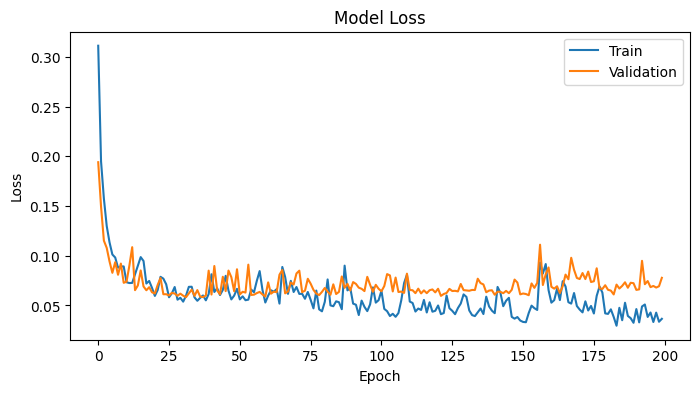

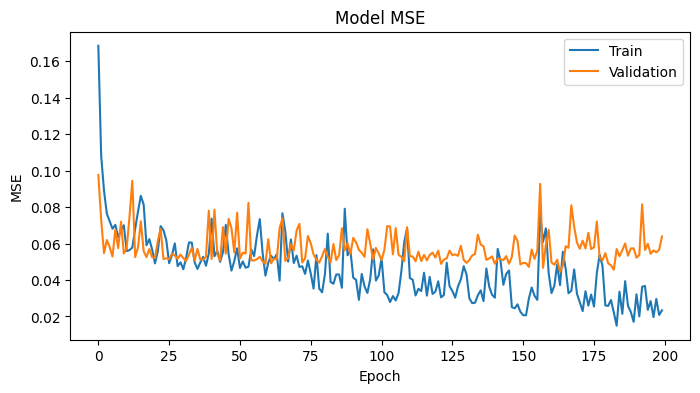

1/1 [==============================] - 1s 611ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               11008     
 nal)                                                            
                                                                 
 repeat_vector_2 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 3, 64)            24832     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 16ms/step - loss: 0.0417 - mse: 0.0387 - val_loss: 0.0520 - val_mse: 0.0491
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0446 - mse: 0.0417 - val_loss: 0.0527 - val_mse: 0.0497
Epoch 54/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0383 - mse: 0.0351 - val_loss: 0.0563 - val_mse: 0.0530
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0358 - mse: 0.0323 - val_loss: 0.0489 - val_mse: 0.0453
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0446 - mse: 0.0407 - val_loss: 0.0432 - val_mse: 0.0390
Epoch 57/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0430 - mse: 0.0387 - val_loss: 0.0585 - val_mse: 0.0541
Epoch 58/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0394 - mse: 0.0349 - val_loss: 0.0436 - val_mse: 0.0387
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0435 

12/12 [==============================] - 0s 13ms/step - loss: 0.0418 - mse: 0.0350 - val_loss: 0.0470 - val_mse: 0.0400
Epoch 114/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0496 - mse: 0.0426 - val_loss: 0.0577 - val_mse: 0.0507
Epoch 115/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0439 - mse: 0.0368 - val_loss: 0.0508 - val_mse: 0.0440
Epoch 116/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0401 - mse: 0.0337 - val_loss: 0.0627 - val_mse: 0.0567
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0366 - mse: 0.0306 - val_loss: 0.0473 - val_mse: 0.0412
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0355 - mse: 0.0294 - val_loss: 0.0644 - val_mse: 0.0582
Epoch 119/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0370 - mse: 0.0306 - val_loss: 0.0396 - val_mse: 0.0328
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0327 - mse: 0.0256 - val_loss: 0.0662 - val_mse: 0.0588
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0392 - mse: 0.0320 - val_loss: 0.0792 - val_mse: 0.0721
Epoch 176/200
12/12 [==============================] - 0s 22ms/step - loss: 0.0426 - mse: 0.0355 - val_loss: 0.0854 - val_mse: 0.0782
Epoch 177/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0303 - mse: 0.0230 - val_loss: 0.0668 - val_mse: 0.0592
Epoch 178/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0305 - mse: 0.0226 - val_loss: 0.0883 - val_mse: 0.0805
Epoch 179/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0324 - mse: 0.0252 - val_loss: 0.0518 - val_mse: 0.0446
Epoch 180/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0364 - mse: 0.0288 - val_loss: 0.0643 - val_mse: 0.0570
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

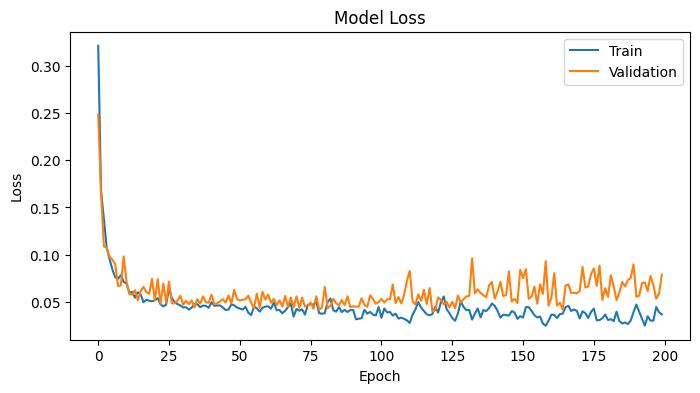

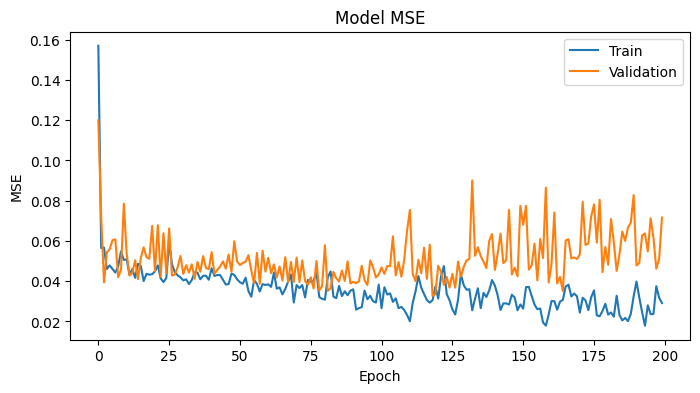

1/1 [==============================] - 1s 627ms/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               11008     
 nal)                                                            
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 3, 64)            24832     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 14ms/step - loss: 0.0567 - mse: 0.0454 - val_loss: 0.1220 - val_mse: 0.1101
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0469 - mse: 0.0345 - val_loss: 0.1609 - val_mse: 0.1478
Epoch 54/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0408 - mse: 0.0287 - val_loss: 0.1047 - val_mse: 0.0939
Epoch 55/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0355 - mse: 0.0252 - val_loss: 0.1365 - val_mse: 0.1268
Epoch 56/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0364 - mse: 0.0272 - val_loss: 0.1096 - val_mse: 0.1009
Epoch 57/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0345 - mse: 0.0257 - val_loss: 0.1180 - val_mse: 0.1089
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0393 - mse: 0.0301 - val_loss: 0.1087 - val_mse: 0.0991
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0442 

12/12 [==============================] - 0s 22ms/step - loss: 0.0267 - mse: 0.0174 - val_loss: 0.1225 - val_mse: 0.1137
Epoch 114/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0258 - mse: 0.0169 - val_loss: 0.1477 - val_mse: 0.1386
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0221 - mse: 0.0135 - val_loss: 0.1324 - val_mse: 0.1244
Epoch 116/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0274 - mse: 0.0195 - val_loss: 0.1407 - val_mse: 0.1327
Epoch 117/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0238 - mse: 0.0159 - val_loss: 0.1348 - val_mse: 0.1269
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0265 - mse: 0.0185 - val_loss: 0.1230 - val_mse: 0.1150
Epoch 119/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0318 - mse: 0.0232 - val_loss: 0.1221 - val_mse: 0.1128
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 14ms/step - loss: 0.0254 - mse: 0.0178 - val_loss: 0.1379 - val_mse: 0.1286
Epoch 175/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0250 - mse: 0.0160 - val_loss: 0.0979 - val_mse: 0.0896
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0294 - mse: 0.0215 - val_loss: 0.1024 - val_mse: 0.0948
Epoch 177/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0215 - mse: 0.0141 - val_loss: 0.1309 - val_mse: 0.1237
Epoch 178/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0245 - mse: 0.0175 - val_loss: 0.1120 - val_mse: 0.1052
Epoch 179/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0359 - mse: 0.0290 - val_loss: 0.1382 - val_mse: 0.1306
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0425 - mse: 0.0342 - val_loss: 0.1397 - val_mse: 0.1307
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

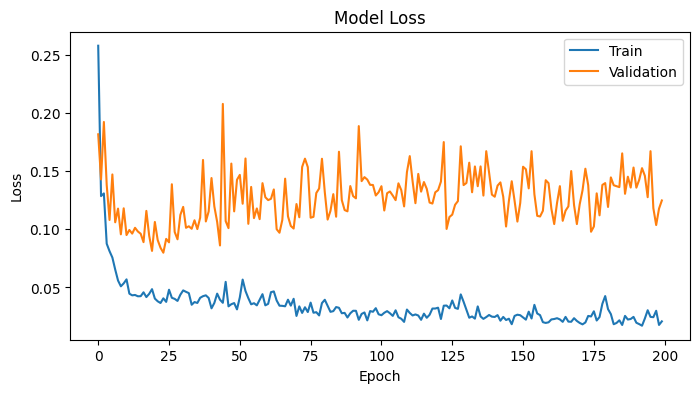

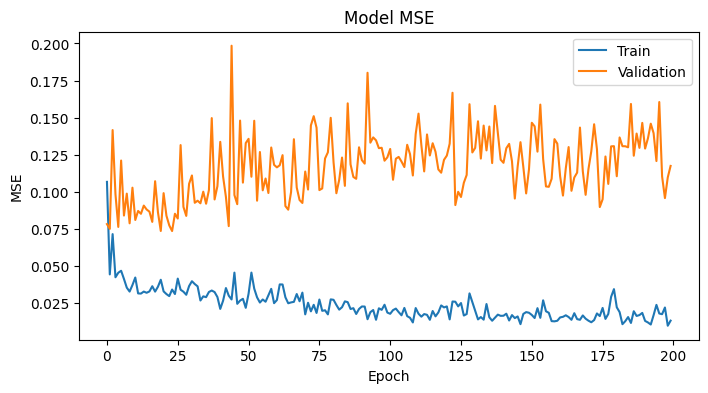

1/1 [==============================] - 1s 587ms/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               11008     
 nal)                                                            
                                                                 
 repeat_vector_4 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_9 (Bidirectio  (None, 3, 64)            24832     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 16ms/step - loss: 0.0433 - mse: 0.0397 - val_loss: 0.0397 - val_mse: 0.0359
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0407 - mse: 0.0370 - val_loss: 0.0397 - val_mse: 0.0359
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0415 - mse: 0.0376 - val_loss: 0.0399 - val_mse: 0.0360
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0482 - mse: 0.0446 - val_loss: 0.0426 - val_mse: 0.0392
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0408 - mse: 0.0373 - val_loss: 0.0407 - val_mse: 0.0371
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0418 - mse: 0.0383 - val_loss: 0.0430 - val_mse: 0.0395
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0409 - mse: 0.0374 - val_loss: 0.0402 - val_mse: 0.0368
Epoch 59/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0401 

12/12 [==============================] - 0s 12ms/step - loss: 0.0403 - mse: 0.0366 - val_loss: 0.0406 - val_mse: 0.0369
Epoch 114/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0400 - mse: 0.0364 - val_loss: 0.0397 - val_mse: 0.0359
Epoch 115/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0367 - mse: 0.0329 - val_loss: 0.0413 - val_mse: 0.0375
Epoch 116/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0397 - mse: 0.0358 - val_loss: 0.0401 - val_mse: 0.0361
Epoch 117/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0400 - mse: 0.0360 - val_loss: 0.0409 - val_mse: 0.0369
Epoch 118/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0371 - mse: 0.0330 - val_loss: 0.0425 - val_mse: 0.0384
Epoch 119/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0442 - mse: 0.0397 - val_loss: 0.0551 - val_mse: 0.0504
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0372 - mse: 0.0320 - val_loss: 0.0408 - val_mse: 0.0356
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0373 - mse: 0.0323 - val_loss: 0.0433 - val_mse: 0.0383
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0422 - mse: 0.0371 - val_loss: 0.0414 - val_mse: 0.0364
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0406 - mse: 0.0356 - val_loss: 0.0417 - val_mse: 0.0364
Epoch 178/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0383 - mse: 0.0325 - val_loss: 0.0437 - val_mse: 0.0380
Epoch 179/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0396 - mse: 0.0344 - val_loss: 0.0498 - val_mse: 0.0449
Epoch 180/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0390 - mse: 0.0341 - val_loss: 0.0436 - val_mse: 0.0387
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

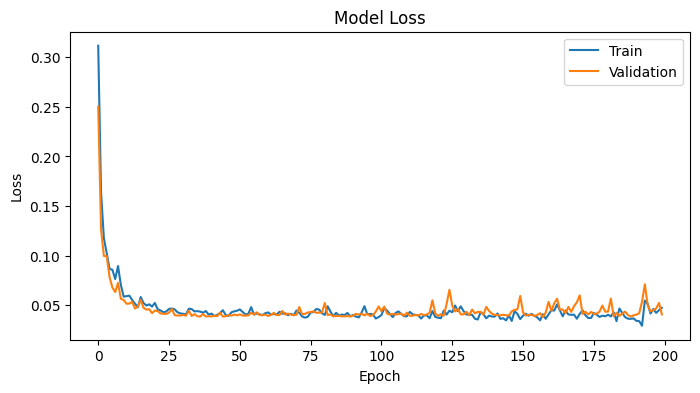

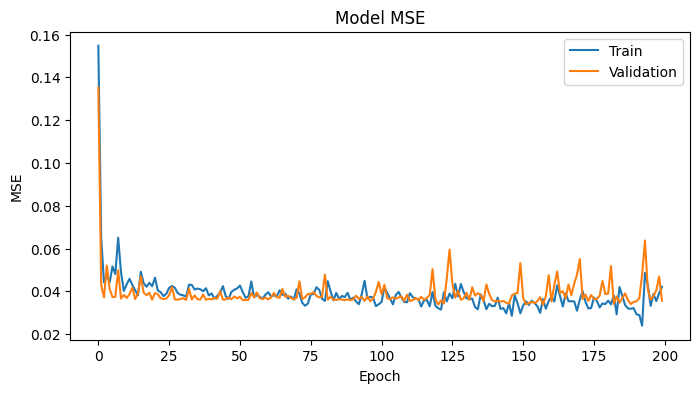

1/1 [==============================] - 1s 769ms/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_11 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 1)             65        
 tribu

Epoch 47/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0721 - mse: 0.0646 - val_loss: 0.0567 - val_mse: 0.0493
Epoch 48/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0746 - mse: 0.0675 - val_loss: 0.0332 - val_mse: 0.0263
Epoch 49/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0733 - mse: 0.0662 - val_loss: 0.0535 - val_mse: 0.0464
Epoch 50/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0847 - mse: 0.0774 - val_loss: 0.0423 - val_mse: 0.0350
Epoch 51/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0719 - mse: 0.0647 - val_loss: 0.0376 - val_mse: 0.0305
Epoch 52/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0712 - mse: 0.0640 - val_loss: 0.0609 - val_mse: 0.0535
Epoch 53/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0731 - mse: 0.0654 - val_loss: 0.0312 - val_mse: 0.0234
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - 

12/12 [==============================] - 0s 13ms/step - loss: 0.0802 - mse: 0.0590 - val_loss: 0.0742 - val_mse: 0.0537
Epoch 109/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0731 - mse: 0.0530 - val_loss: 0.0881 - val_mse: 0.0688
Epoch 110/200
12/12 [==============================] - 0s 27ms/step - loss: 0.0630 - mse: 0.0439 - val_loss: 0.1179 - val_mse: 0.0987
Epoch 111/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0617 - mse: 0.0424 - val_loss: 0.0849 - val_mse: 0.0655
Epoch 112/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0772 - mse: 0.0549 - val_loss: 0.0961 - val_mse: 0.0705
Epoch 113/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0647 - mse: 0.0376 - val_loss: 0.1528 - val_mse: 0.1256
Epoch 114/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0713 - mse: 0.0422 - val_loss: 0.1308 - val_mse: 0.0993
Epoch 115/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 12ms/step - loss: 0.0341 - mse: 0.0140 - val_loss: 0.1918 - val_mse: 0.1725
Epoch 170/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0351 - mse: 0.0157 - val_loss: 0.1958 - val_mse: 0.1764
Epoch 171/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0321 - mse: 0.0129 - val_loss: 0.2243 - val_mse: 0.2051
Epoch 172/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0371 - mse: 0.0178 - val_loss: 0.1448 - val_mse: 0.1258
Epoch 173/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0626 - mse: 0.0436 - val_loss: 0.1216 - val_mse: 0.1027
Epoch 174/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0388 - mse: 0.0202 - val_loss: 0.1607 - val_mse: 0.1423
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0329 - mse: 0.0147 - val_loss: 0.1905 - val_mse: 0.1728
Epoch 176/200
12/12 [==============================] - 0s 13ms/step - loss: 

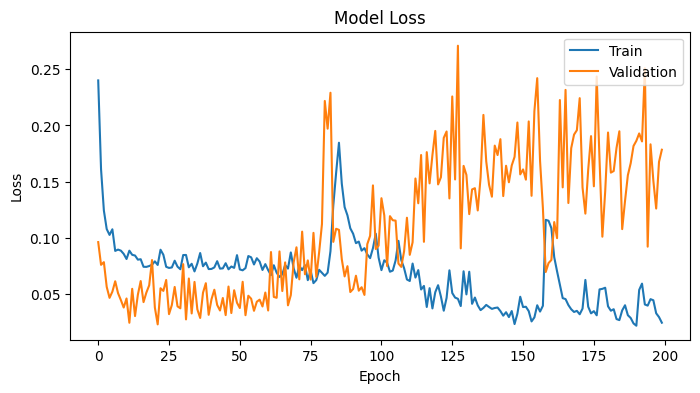

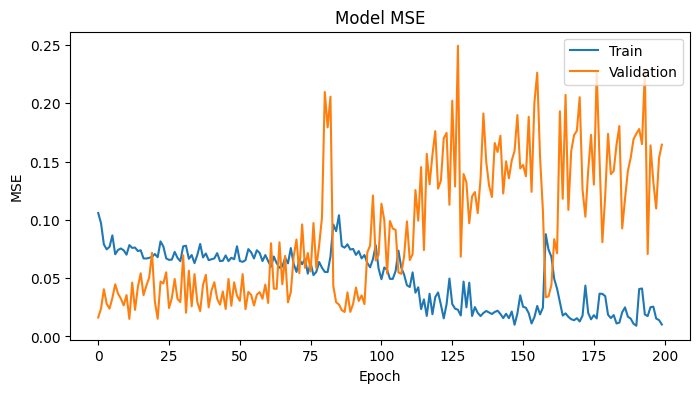

1/1 [==============================] - 385s 385s/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_6 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_13 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDis  (None, 3, 1)             65        
 trib

Epoch 47/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0381 - mse: 0.0283 - val_loss: 0.1051 - val_mse: 0.0954
Epoch 48/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0408 - mse: 0.0311 - val_loss: 0.0436 - val_mse: 0.0334
Epoch 49/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0339 - mse: 0.0232 - val_loss: 0.0750 - val_mse: 0.0638
Epoch 50/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0394 - mse: 0.0282 - val_loss: 0.0338 - val_mse: 0.0228
Epoch 51/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0357 - mse: 0.0254 - val_loss: 0.0343 - val_mse: 0.0239
Epoch 52/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0372 - mse: 0.0259 - val_loss: 0.0546 - val_mse: 0.0427
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0505 - mse: 0.0389 - val_loss: 0.1117 - val_mse: 0.0986
Epoch 54/200
12/12 [==============================] - 0s 18ms/step - 

12/12 [==============================] - 0s 15ms/step - loss: 0.0240 - mse: 0.0133 - val_loss: 0.0291 - val_mse: 0.0185
Epoch 109/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0210 - mse: 0.0098 - val_loss: 0.0181 - val_mse: 0.0065
Epoch 110/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0219 - mse: 0.0103 - val_loss: 0.0735 - val_mse: 0.0626
Epoch 111/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0238 - mse: 0.0133 - val_loss: 0.0323 - val_mse: 0.0211
Epoch 112/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0436 - mse: 0.0315 - val_loss: 0.0556 - val_mse: 0.0425
Epoch 113/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0247 - mse: 0.0104 - val_loss: 0.0260 - val_mse: 0.0115
Epoch 114/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0358 - mse: 0.0217 - val_loss: 0.0609 - val_mse: 0.0450
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 

12/12 [==============================] - 0s 16ms/step - loss: 0.0405 - mse: 0.0262 - val_loss: 0.0330 - val_mse: 0.0184
Epoch 170/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0292 - mse: 0.0144 - val_loss: 0.0187 - val_mse: 0.0038
Epoch 171/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0363 - mse: 0.0212 - val_loss: 0.0650 - val_mse: 0.0498
Epoch 172/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0287 - mse: 0.0138 - val_loss: 0.0301 - val_mse: 0.0159
Epoch 173/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0277 - mse: 0.0140 - val_loss: 0.0197 - val_mse: 0.0065
Epoch 174/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0250 - mse: 0.0120 - val_loss: 0.0250 - val_mse: 0.0122
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0202 - mse: 0.0079 - val_loss: 0.0203 - val_mse: 0.0088
Epoch 176/200
12/12 [==============================] - 0s 13ms/step - loss: 

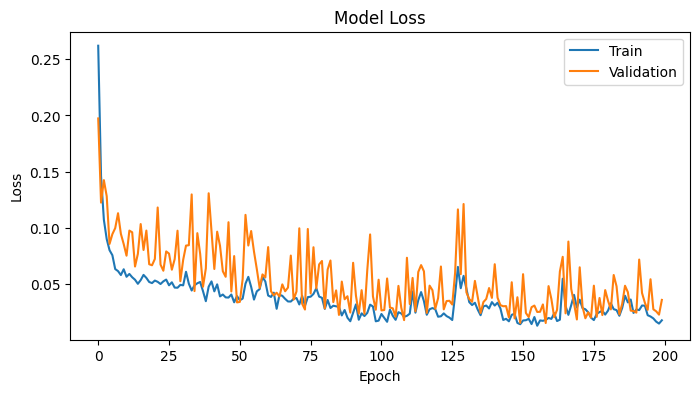

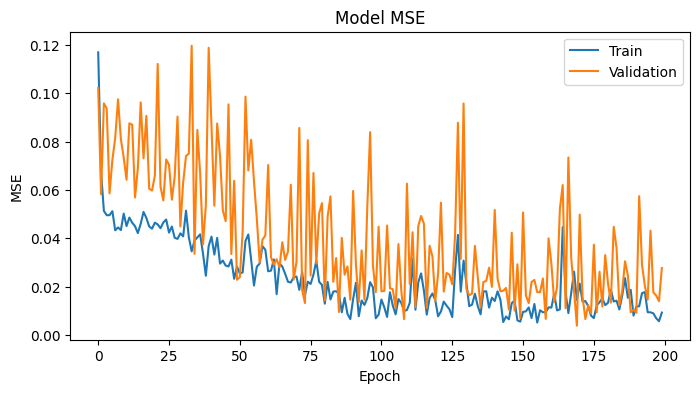

1/1 [==============================] - 1s 797ms/step
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_7 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_15 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_7 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 14ms/step - loss: 0.0591 - mse: 0.0445 - val_loss: 0.1017 - val_mse: 0.0890
Epoch 53/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0525 - mse: 0.0418 - val_loss: 0.1265 - val_mse: 0.1180
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0501 - mse: 0.0425 - val_loss: 0.0997 - val_mse: 0.0931
Epoch 55/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0447 - mse: 0.0386 - val_loss: 0.0882 - val_mse: 0.0824
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0476 - mse: 0.0421 - val_loss: 0.0984 - val_mse: 0.0931
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0424 - mse: 0.0366 - val_loss: 0.1034 - val_mse: 0.0976
Epoch 58/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0404 - mse: 0.0349 - val_loss: 0.0794 - val_mse: 0.0736
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0366 

12/12 [==============================] - 0s 14ms/step - loss: 0.0286 - mse: 0.0191 - val_loss: 0.0771 - val_mse: 0.0680
Epoch 114/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0255 - mse: 0.0166 - val_loss: 0.0846 - val_mse: 0.0760
Epoch 115/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0255 - mse: 0.0172 - val_loss: 0.0649 - val_mse: 0.0571
Epoch 116/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0284 - mse: 0.0212 - val_loss: 0.0695 - val_mse: 0.0627
Epoch 117/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0262 - mse: 0.0189 - val_loss: 0.0798 - val_mse: 0.0716
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0291 - mse: 0.0204 - val_loss: 0.0657 - val_mse: 0.0562
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0369 - mse: 0.0263 - val_loss: 0.0809 - val_mse: 0.0695
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 14ms/step - loss: 0.0426 - mse: 0.0289 - val_loss: 0.0933 - val_mse: 0.0781
Epoch 175/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0428 - mse: 0.0249 - val_loss: 0.0931 - val_mse: 0.0735
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0424 - mse: 0.0235 - val_loss: 0.0891 - val_mse: 0.0716
Epoch 177/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0363 - mse: 0.0202 - val_loss: 0.0786 - val_mse: 0.0639
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0368 - mse: 0.0229 - val_loss: 0.0858 - val_mse: 0.0719
Epoch 179/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0322 - mse: 0.0175 - val_loss: 0.0912 - val_mse: 0.0766
Epoch 180/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0279 - mse: 0.0139 - val_loss: 0.0795 - val_mse: 0.0664
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

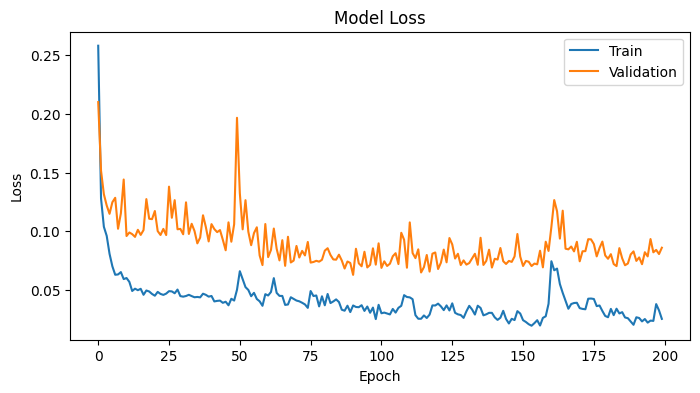

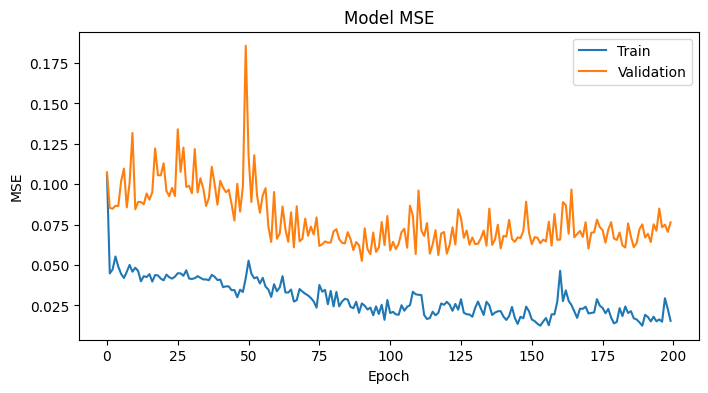

1/1 [==============================] - 1s 650ms/step
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_8 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_17 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_8 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 18ms/step - loss: 0.0675 - mse: 0.0661 - val_loss: 0.0398 - val_mse: 0.0384
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0673 - mse: 0.0658 - val_loss: 0.0416 - val_mse: 0.0400
Epoch 54/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0610 - mse: 0.0592 - val_loss: 0.0460 - val_mse: 0.0442
Epoch 55/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0616 - mse: 0.0599 - val_loss: 0.0406 - val_mse: 0.0391
Epoch 56/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0629 - mse: 0.0614 - val_loss: 0.0432 - val_mse: 0.0418
Epoch 57/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0608 - mse: 0.0595 - val_loss: 0.0469 - val_mse: 0.0457
Epoch 58/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0607 - mse: 0.0596 - val_loss: 0.0431 - val_mse: 0.0420
Epoch 59/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0633 

12/12 [==============================] - 0s 15ms/step - loss: 0.0575 - mse: 0.0521 - val_loss: 0.0542 - val_mse: 0.0489
Epoch 114/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0574 - mse: 0.0518 - val_loss: 0.0554 - val_mse: 0.0492
Epoch 115/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0617 - mse: 0.0548 - val_loss: 0.0464 - val_mse: 0.0386
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0651 - mse: 0.0559 - val_loss: 0.0687 - val_mse: 0.0592
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0741 - mse: 0.0652 - val_loss: 0.0472 - val_mse: 0.0388
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0687 - mse: 0.0608 - val_loss: 0.0596 - val_mse: 0.0524
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0661 - mse: 0.0590 - val_loss: 0.0623 - val_mse: 0.0557
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 16ms/step - loss: 0.0678 - mse: 0.0598 - val_loss: 0.0711 - val_mse: 0.0620
Epoch 175/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0679 - mse: 0.0568 - val_loss: 0.0654 - val_mse: 0.0520
Epoch 176/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0728 - mse: 0.0590 - val_loss: 0.0583 - val_mse: 0.0449
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0702 - mse: 0.0580 - val_loss: 0.0544 - val_mse: 0.0434
Epoch 178/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0568 - mse: 0.0469 - val_loss: 0.0557 - val_mse: 0.0470
Epoch 179/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0536 - mse: 0.0450 - val_loss: 0.0673 - val_mse: 0.0590
Epoch 180/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0602 - mse: 0.0518 - val_loss: 0.0549 - val_mse: 0.0462
Epoch 181/200
12/12 [==============================] - 0s 14ms/step - loss: 

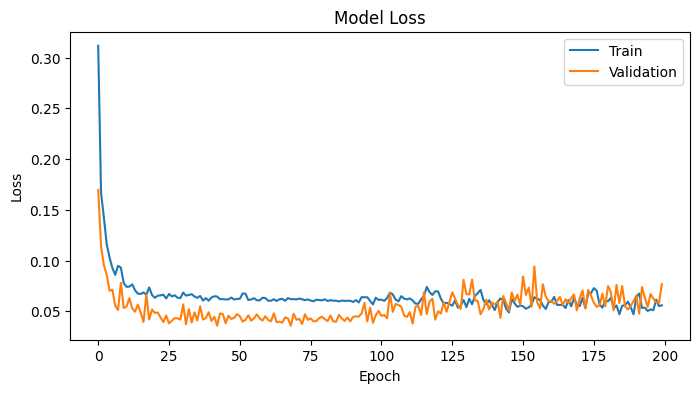

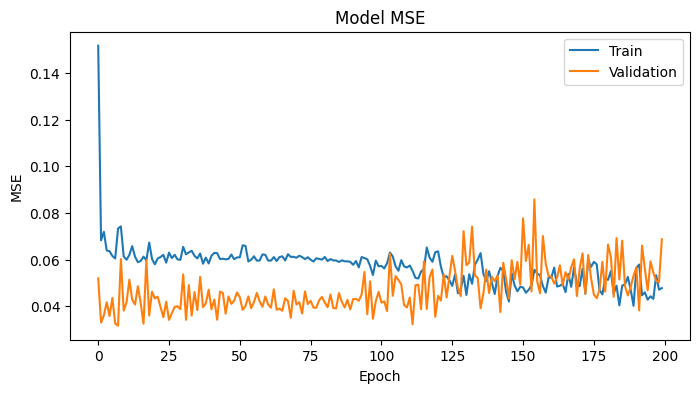

1/1 [==============================] - 1s 668ms/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_9 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 bidirectional_19 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_9 (TimeDis  (None, 3, 1)             65        
 tribu

12/12 [==============================] - 0s 14ms/step - loss: 0.0826 - mse: 0.0817 - val_loss: 0.1202 - val_mse: 0.1192
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0816 - mse: 0.0806 - val_loss: 0.1242 - val_mse: 0.1232
Epoch 54/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0805 - mse: 0.0795 - val_loss: 0.1195 - val_mse: 0.1184
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0834 - mse: 0.0823 - val_loss: 0.1184 - val_mse: 0.1173
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0828 - mse: 0.0816 - val_loss: 0.1202 - val_mse: 0.1191
Epoch 57/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0819 - mse: 0.0808 - val_loss: 0.1295 - val_mse: 0.1284
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0816 - mse: 0.0806 - val_loss: 0.1155 - val_mse: 0.1146
Epoch 59/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0837 

12/12 [==============================] - 0s 17ms/step - loss: 0.0753 - mse: 0.0677 - val_loss: 0.1016 - val_mse: 0.0938
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0729 - mse: 0.0645 - val_loss: 0.0986 - val_mse: 0.0902
Epoch 115/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0797 - mse: 0.0710 - val_loss: 0.0749 - val_mse: 0.0660
Epoch 116/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0906 - mse: 0.0808 - val_loss: 0.1587 - val_mse: 0.1478
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0907 - mse: 0.0805 - val_loss: 0.1097 - val_mse: 0.1005
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0846 - mse: 0.0756 - val_loss: 0.1068 - val_mse: 0.0979
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0759 - mse: 0.0669 - val_loss: 0.0886 - val_mse: 0.0802
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0689 - mse: 0.0537 - val_loss: 0.1081 - val_mse: 0.0935
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0576 - mse: 0.0416 - val_loss: 0.1178 - val_mse: 0.0998
Epoch 176/200
12/12 [==============================] - 0s 18ms/step - loss: 0.1065 - mse: 0.0879 - val_loss: 0.1256 - val_mse: 0.1073
Epoch 177/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0852 - mse: 0.0658 - val_loss: 0.0929 - val_mse: 0.0738
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0764 - mse: 0.0586 - val_loss: 0.1101 - val_mse: 0.0936
Epoch 179/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0746 - mse: 0.0590 - val_loss: 0.0933 - val_mse: 0.0783
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0597 - mse: 0.0446 - val_loss: 0.0921 - val_mse: 0.0772
Epoch 181/200
12/12 [==============================] - 0s 18ms/step - loss: 

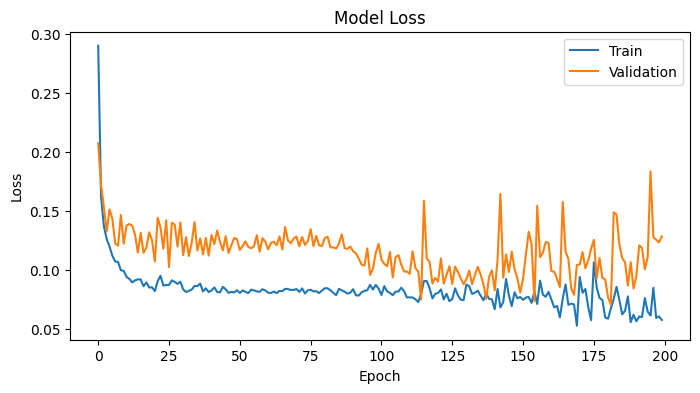

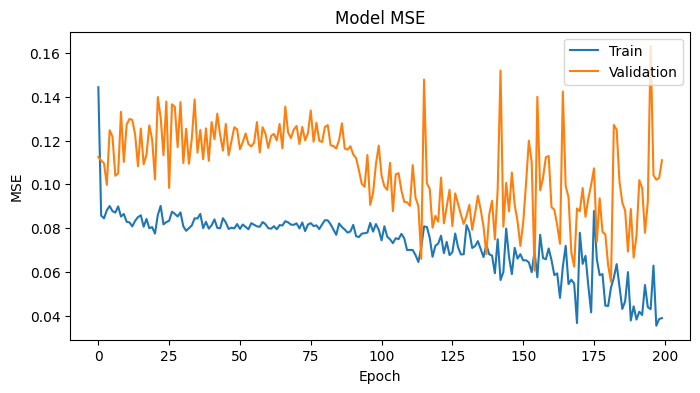

1/1 [==============================] - 1s 631ms/step
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_10 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_21 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 17ms/step - loss: 0.0412 - mse: 0.0379 - val_loss: 0.0741 - val_mse: 0.0710
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0358 - mse: 0.0327 - val_loss: 0.0635 - val_mse: 0.0602
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0377 - mse: 0.0343 - val_loss: 0.1418 - val_mse: 0.1386
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0460 - mse: 0.0427 - val_loss: 0.0698 - val_mse: 0.0664
Epoch 56/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0422 - mse: 0.0386 - val_loss: 0.0698 - val_mse: 0.0661
Epoch 57/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0414 - mse: 0.0379 - val_loss: 0.0927 - val_mse: 0.0891
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0421 - mse: 0.0384 - val_loss: 0.0641 - val_mse: 0.0605
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0390 

12/12 [==============================] - 0s 16ms/step - loss: 0.0433 - mse: 0.0368 - val_loss: 0.0540 - val_mse: 0.0473
Epoch 114/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0395 - mse: 0.0331 - val_loss: 0.0599 - val_mse: 0.0538
Epoch 115/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0341 - mse: 0.0283 - val_loss: 0.0772 - val_mse: 0.0716
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0375 - mse: 0.0320 - val_loss: 0.0442 - val_mse: 0.0387
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0336 - mse: 0.0282 - val_loss: 0.0726 - val_mse: 0.0672
Epoch 118/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0431 - mse: 0.0377 - val_loss: 0.0660 - val_mse: 0.0606
Epoch 119/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0354 - mse: 0.0299 - val_loss: 0.0438 - val_mse: 0.0381
Epoch 120/200
12/12 [==============================] - 0s 16ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0312 - mse: 0.0243 - val_loss: 0.0703 - val_mse: 0.0638
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0331 - mse: 0.0267 - val_loss: 0.0399 - val_mse: 0.0338
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0264 - mse: 0.0204 - val_loss: 0.0539 - val_mse: 0.0480
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0291 - mse: 0.0231 - val_loss: 0.0664 - val_mse: 0.0606
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0328 - mse: 0.0269 - val_loss: 0.0449 - val_mse: 0.0387
Epoch 179/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0289 - mse: 0.0225 - val_loss: 0.0416 - val_mse: 0.0351
Epoch 180/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0313 - mse: 0.0249 - val_loss: 0.0460 - val_mse: 0.0396
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

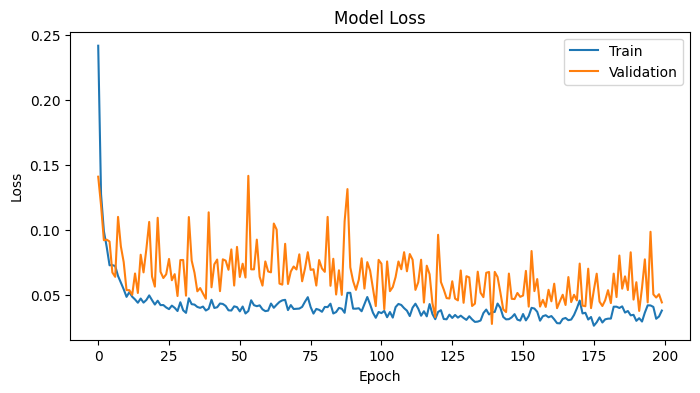

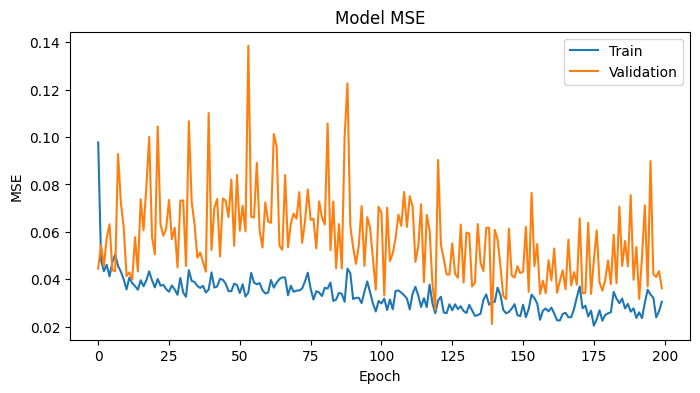

1/1 [==============================] - 1s 1s/step
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_11 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_23 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 3, 1)             65        
 stribut

12/12 [==============================] - 0s 17ms/step - loss: 0.0223 - mse: 0.0109 - val_loss: 0.0219 - val_mse: 0.0107
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0171 - mse: 0.0064 - val_loss: 0.0189 - val_mse: 0.0084
Epoch 54/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0198 - mse: 0.0098 - val_loss: 0.0138 - val_mse: 0.0045
Epoch 55/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0177 - mse: 0.0080 - val_loss: 0.0300 - val_mse: 0.0199
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0198 - mse: 0.0103 - val_loss: 0.0116 - val_mse: 0.0030
Epoch 57/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0202 - mse: 0.0115 - val_loss: 0.0223 - val_mse: 0.0137
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0234 - mse: 0.0148 - val_loss: 0.0261 - val_mse: 0.0170
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0185 

12/12 [==============================] - 0s 18ms/step - loss: 0.0262 - mse: 0.0097 - val_loss: 0.0199 - val_mse: 0.0045
Epoch 114/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0228 - mse: 0.0061 - val_loss: 0.0388 - val_mse: 0.0201
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0488 - mse: 0.0280 - val_loss: 0.0288 - val_mse: 0.0056
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0347 - mse: 0.0111 - val_loss: 0.0275 - val_mse: 0.0036
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0402 - mse: 0.0164 - val_loss: 0.0476 - val_mse: 0.0229
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0347 - mse: 0.0094 - val_loss: 0.0299 - val_mse: 0.0048
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0286 - mse: 0.0047 - val_loss: 0.0349 - val_mse: 0.0127
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.1247 - mse: 0.0966 - val_loss: 0.0708 - val_mse: 0.0232
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.1147 - mse: 0.0602 - val_loss: 0.0689 - val_mse: 0.0107
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0731 - mse: 0.0124 - val_loss: 0.0863 - val_mse: 0.0251
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0794 - mse: 0.0229 - val_loss: 0.0565 - val_mse: 0.0058
Epoch 178/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0630 - mse: 0.0114 - val_loss: 0.0593 - val_mse: 0.0082
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0723 - mse: 0.0233 - val_loss: 0.0532 - val_mse: 0.0061
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0538 - mse: 0.0092 - val_loss: 0.0475 - val_mse: 0.0066
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

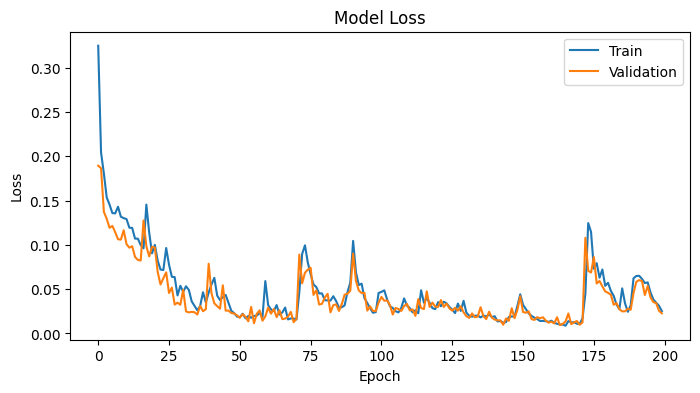

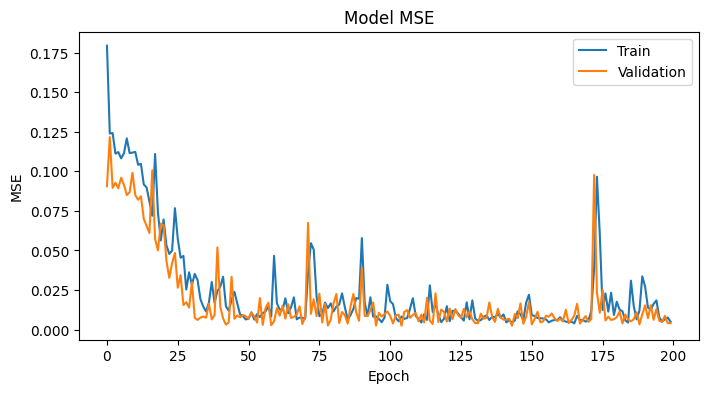

1/1 [==============================] - 1s 688ms/step
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_12 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_25 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 17ms/step - loss: 0.0466 - mse: 0.0320 - val_loss: 0.1460 - val_mse: 0.1301
Epoch 53/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0537 - mse: 0.0362 - val_loss: 0.0754 - val_mse: 0.0563
Epoch 54/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0454 - mse: 0.0258 - val_loss: 0.1175 - val_mse: 0.0979
Epoch 55/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0390 - mse: 0.0190 - val_loss: 0.0307 - val_mse: 0.0107
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0352 - mse: 0.0159 - val_loss: 0.0818 - val_mse: 0.0632
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0405 - mse: 0.0226 - val_loss: 0.0284 - val_mse: 0.0111
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0469 - mse: 0.0296 - val_loss: 0.0693 - val_mse: 0.0527
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0389 

12/12 [==============================] - 0s 18ms/step - loss: 0.0224 - mse: 0.0109 - val_loss: 0.0327 - val_mse: 0.0211
Epoch 114/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0342 - mse: 0.0224 - val_loss: 0.0428 - val_mse: 0.0300
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0328 - mse: 0.0190 - val_loss: 0.0244 - val_mse: 0.0105
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0302 - mse: 0.0167 - val_loss: 0.0484 - val_mse: 0.0355
Epoch 117/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0274 - mse: 0.0151 - val_loss: 0.0251 - val_mse: 0.0136
Epoch 118/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0195 - mse: 0.0084 - val_loss: 0.0392 - val_mse: 0.0287
Epoch 119/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0205 - mse: 0.0103 - val_loss: 0.0339 - val_mse: 0.0241
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0434 - mse: 0.0261 - val_loss: 0.0484 - val_mse: 0.0310
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0295 - mse: 0.0123 - val_loss: 0.0386 - val_mse: 0.0217
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0458 - mse: 0.0289 - val_loss: 0.0651 - val_mse: 0.0478
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0452 - mse: 0.0279 - val_loss: 0.0559 - val_mse: 0.0389
Epoch 178/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0321 - mse: 0.0154 - val_loss: 0.0328 - val_mse: 0.0169
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0290 - mse: 0.0137 - val_loss: 0.0334 - val_mse: 0.0190
Epoch 180/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0243 - mse: 0.0105 - val_loss: 0.0379 - val_mse: 0.0245
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

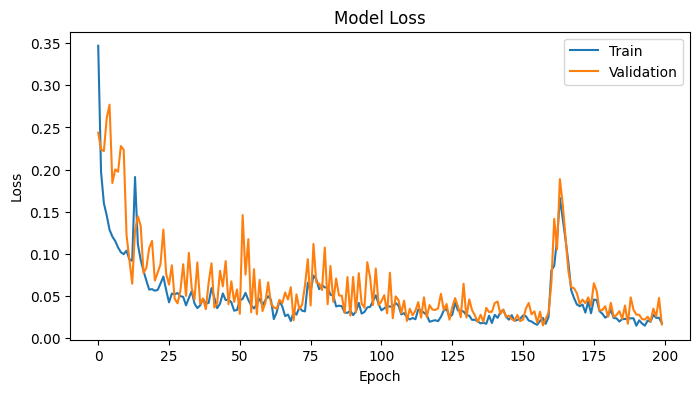

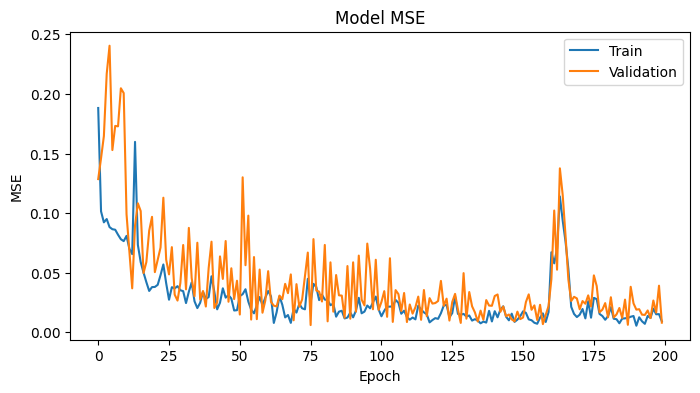

1/1 [==============================] - 1s 662ms/step
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_26 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_13 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_27 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 17ms/step - loss: 0.0907 - mse: 0.0795 - val_loss: 0.1451 - val_mse: 0.1337
Epoch 53/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0804 - mse: 0.0680 - val_loss: 0.1360 - val_mse: 0.1225
Epoch 54/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0961 - mse: 0.0817 - val_loss: 0.1894 - val_mse: 0.1732
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0947 - mse: 0.0782 - val_loss: 0.1339 - val_mse: 0.1173
Epoch 56/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0715 - mse: 0.0554 - val_loss: 0.1559 - val_mse: 0.1403
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0745 - mse: 0.0580 - val_loss: 0.1366 - val_mse: 0.1195
Epoch 58/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0770 - mse: 0.0599 - val_loss: 0.1393 - val_mse: 0.1229
Epoch 59/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0849 

12/12 [==============================] - 0s 14ms/step - loss: 0.0985 - mse: 0.0742 - val_loss: 0.1155 - val_mse: 0.0904
Epoch 114/200
12/12 [==============================] - 0s 13ms/step - loss: 0.1039 - mse: 0.0784 - val_loss: 0.1239 - val_mse: 0.0990
Epoch 115/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0799 - mse: 0.0562 - val_loss: 0.0779 - val_mse: 0.0559
Epoch 116/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0640 - mse: 0.0425 - val_loss: 0.1348 - val_mse: 0.1133
Epoch 117/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0560 - mse: 0.0343 - val_loss: 0.1307 - val_mse: 0.1088
Epoch 118/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0712 - mse: 0.0495 - val_loss: 0.0900 - val_mse: 0.0689
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0679 - mse: 0.0461 - val_loss: 0.0673 - val_mse: 0.0438
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0346 - mse: 0.0132 - val_loss: 0.1256 - val_mse: 0.1050
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0369 - mse: 0.0168 - val_loss: 0.1042 - val_mse: 0.0846
Epoch 176/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0481 - mse: 0.0288 - val_loss: 0.1200 - val_mse: 0.1009
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0421 - mse: 0.0234 - val_loss: 0.1085 - val_mse: 0.0908
Epoch 178/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0378 - mse: 0.0205 - val_loss: 0.1402 - val_mse: 0.1233
Epoch 179/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0336 - mse: 0.0169 - val_loss: 0.1259 - val_mse: 0.1095
Epoch 180/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0367 - mse: 0.0205 - val_loss: 0.1089 - val_mse: 0.0927
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

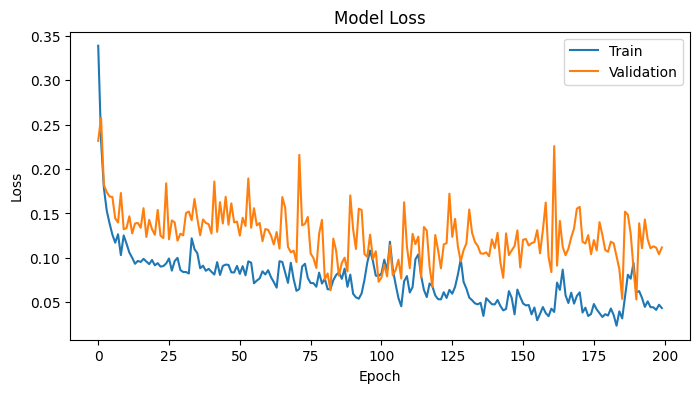

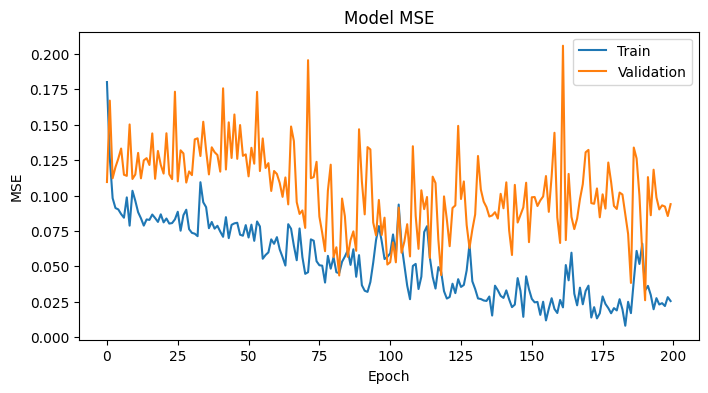

1/1 [==============================] - 1s 752ms/step
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_14 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_29 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 21ms/step - loss: 0.0270 - mse: 0.0093 - val_loss: 0.0269 - val_mse: 0.0095
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0338 - mse: 0.0168 - val_loss: 0.0380 - val_mse: 0.0211
Epoch 54/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0473 - mse: 0.0299 - val_loss: 0.0383 - val_mse: 0.0200
Epoch 55/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0402 - mse: 0.0214 - val_loss: 0.0373 - val_mse: 0.0186
Epoch 56/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0324 - mse: 0.0150 - val_loss: 0.0256 - val_mse: 0.0100
Epoch 57/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0249 - mse: 0.0103 - val_loss: 0.0233 - val_mse: 0.0098
Epoch 58/200
12/12 [==============================] - 0s 26ms/step - loss: 0.0287 - mse: 0.0156 - val_loss: 0.0207 - val_mse: 0.0077
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0272 

12/12 [==============================] - 0s 18ms/step - loss: 0.0896 - mse: 0.0699 - val_loss: 0.0541 - val_mse: 0.0243
Epoch 114/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0678 - mse: 0.0313 - val_loss: 0.0489 - val_mse: 0.0061
Epoch 115/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0559 - mse: 0.0121 - val_loss: 0.0553 - val_mse: 0.0128
Epoch 116/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0500 - mse: 0.0103 - val_loss: 0.0467 - val_mse: 0.0110
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0373 - mse: 0.0051 - val_loss: 0.0361 - val_mse: 0.0079
Epoch 118/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0382 - mse: 0.0116 - val_loss: 0.0392 - val_mse: 0.0142
Epoch 119/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0277 - mse: 0.0042 - val_loss: 0.0346 - val_mse: 0.0128
Epoch 120/200
12/12 [==============================] - 0s 18ms/step - loss: 

12/12 [==============================] - 0s 18ms/step - loss: 0.0230 - mse: 0.0165 - val_loss: 0.0247 - val_mse: 0.0153
Epoch 175/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0245 - mse: 0.0123 - val_loss: 0.0339 - val_mse: 0.0193
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0276 - mse: 0.0129 - val_loss: 0.0169 - val_mse: 0.0021
Epoch 177/200
12/12 [==============================] - 0s 22ms/step - loss: 0.0249 - mse: 0.0108 - val_loss: 0.0379 - val_mse: 0.0247
Epoch 178/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0185 - mse: 0.0062 - val_loss: 0.0164 - val_mse: 0.0052
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0142 - mse: 0.0038 - val_loss: 0.0193 - val_mse: 0.0097
Epoch 180/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0133 - mse: 0.0044 - val_loss: 0.0161 - val_mse: 0.0079
Epoch 181/200
12/12 [==============================] - 0s 22ms/step - loss: 

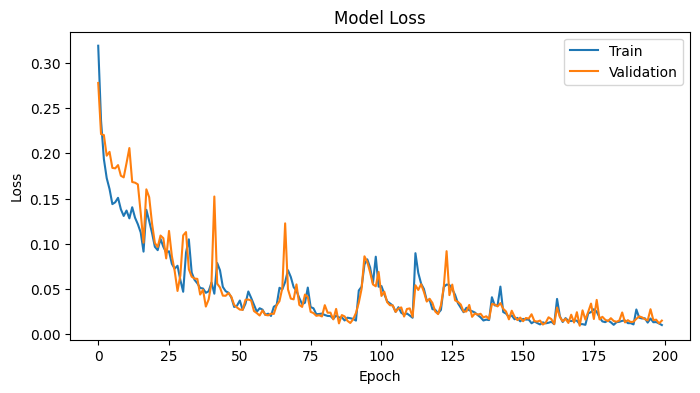

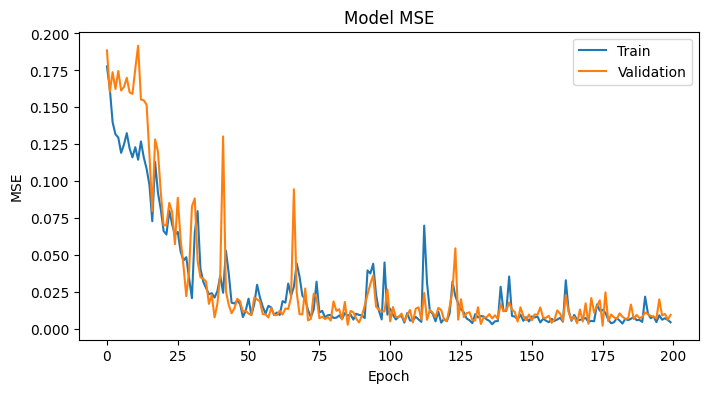

1/1 [==============================] - 1s 806ms/step
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_30 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_15 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_31 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 15ms/step - loss: 0.0465 - mse: 0.0135 - val_loss: 0.0612 - val_mse: 0.0263
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0485 - mse: 0.0143 - val_loss: 0.0738 - val_mse: 0.0407
Epoch 54/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0412 - mse: 0.0124 - val_loss: 0.0488 - val_mse: 0.0240
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0300 - mse: 0.0073 - val_loss: 0.0318 - val_mse: 0.0117
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0298 - mse: 0.0118 - val_loss: 0.0376 - val_mse: 0.0213
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0245 - mse: 0.0088 - val_loss: 0.0212 - val_mse: 0.0055
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0248 - mse: 0.0085 - val_loss: 0.0441 - val_mse: 0.0274
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0297 

12/12 [==============================] - 0s 13ms/step - loss: 0.0143 - mse: 0.0070 - val_loss: 0.0169 - val_mse: 0.0092
Epoch 114/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0124 - mse: 0.0050 - val_loss: 0.0271 - val_mse: 0.0197
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0133 - mse: 0.0055 - val_loss: 0.0180 - val_mse: 0.0097
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0170 - mse: 0.0089 - val_loss: 0.0293 - val_mse: 0.0214
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0138 - mse: 0.0061 - val_loss: 0.0139 - val_mse: 0.0065
Epoch 118/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0109 - mse: 0.0045 - val_loss: 0.0262 - val_mse: 0.0206
Epoch 119/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0103 - mse: 0.0050 - val_loss: 0.0148 - val_mse: 0.0096
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 16ms/step - loss: 0.0255 - mse: 0.0028 - val_loss: 0.0316 - val_mse: 0.0097
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0468 - mse: 0.0230 - val_loss: 0.1382 - val_mse: 0.1089
Epoch 176/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0870 - mse: 0.0540 - val_loss: 0.1070 - val_mse: 0.0701
Epoch 177/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0763 - mse: 0.0357 - val_loss: 0.0739 - val_mse: 0.0303
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0541 - mse: 0.0102 - val_loss: 0.0654 - val_mse: 0.0228
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0449 - mse: 0.0031 - val_loss: 0.0523 - val_mse: 0.0129
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0400 - mse: 0.0034 - val_loss: 0.0455 - val_mse: 0.0120
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

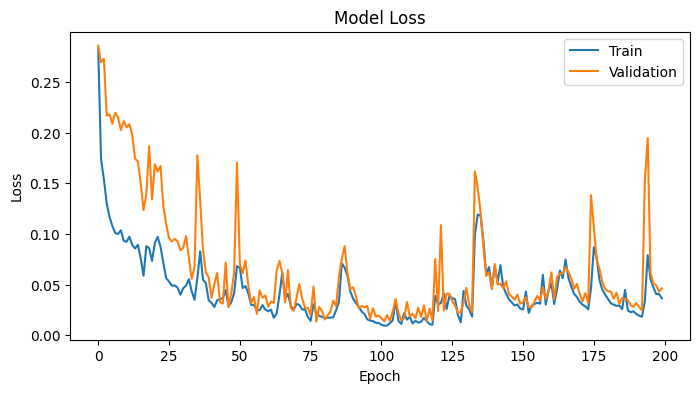

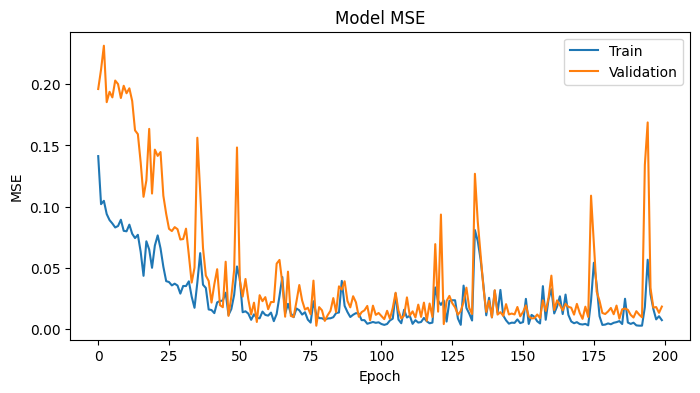

1/1 [==============================] - 1s 1s/step
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_32 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_16 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_33 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 3, 1)             65        
 stribut

12/12 [==============================] - 0s 13ms/step - loss: 0.0248 - mse: 0.0124 - val_loss: 0.0571 - val_mse: 0.0450
Epoch 53/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0175 - mse: 0.0058 - val_loss: 0.0539 - val_mse: 0.0427
Epoch 54/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0182 - mse: 0.0071 - val_loss: 0.0510 - val_mse: 0.0402
Epoch 55/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0190 - mse: 0.0090 - val_loss: 0.0597 - val_mse: 0.0501
Epoch 56/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0235 - mse: 0.0140 - val_loss: 0.0540 - val_mse: 0.0443
Epoch 57/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0257 - mse: 0.0159 - val_loss: 0.0751 - val_mse: 0.0653
Epoch 58/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0251 - mse: 0.0150 - val_loss: 0.0568 - val_mse: 0.0461
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0191 

12/12 [==============================] - 0s 13ms/step - loss: 0.0179 - mse: 0.0104 - val_loss: 0.0471 - val_mse: 0.0382
Epoch 114/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0243 - mse: 0.0154 - val_loss: 0.0556 - val_mse: 0.0443
Epoch 115/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0314 - mse: 0.0173 - val_loss: 0.0517 - val_mse: 0.0368
Epoch 116/200
12/12 [==============================] - 0s 12ms/step - loss: 0.0290 - mse: 0.0144 - val_loss: 0.0650 - val_mse: 0.0511
Epoch 117/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0215 - mse: 0.0084 - val_loss: 0.0454 - val_mse: 0.0327
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0196 - mse: 0.0070 - val_loss: 0.0517 - val_mse: 0.0385
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0182 - mse: 0.0048 - val_loss: 0.0372 - val_mse: 0.0242
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0296 - mse: 0.0068 - val_loss: 0.0498 - val_mse: 0.0280
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0302 - mse: 0.0097 - val_loss: 0.0464 - val_mse: 0.0270
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0237 - mse: 0.0049 - val_loss: 0.0574 - val_mse: 0.0393
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0221 - mse: 0.0045 - val_loss: 0.0564 - val_mse: 0.0395
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0204 - mse: 0.0042 - val_loss: 0.0486 - val_mse: 0.0332
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0186 - mse: 0.0037 - val_loss: 0.0474 - val_mse: 0.0333
Epoch 180/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0155 - mse: 0.0019 - val_loss: 0.0436 - val_mse: 0.0305
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

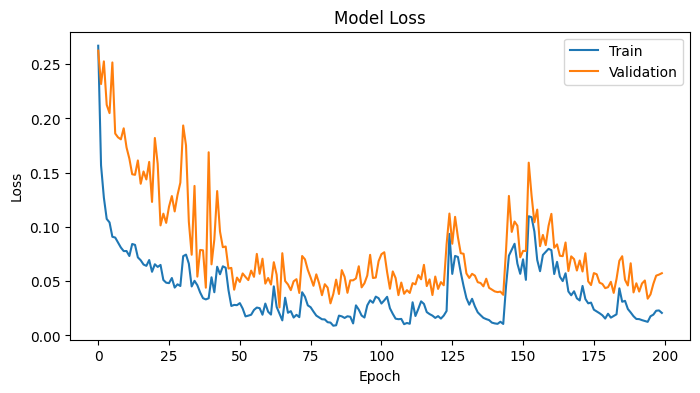

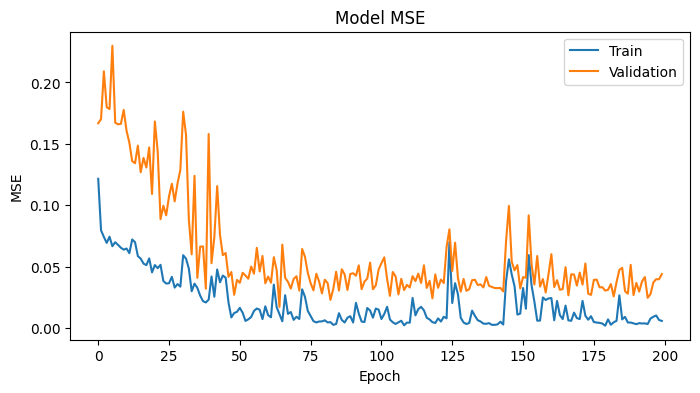

1/1 [==============================] - 1s 893ms/step
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_34 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_17 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_35 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 14ms/step - loss: 0.0682 - mse: 0.0462 - val_loss: 0.0552 - val_mse: 0.0303
Epoch 53/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0471 - mse: 0.0208 - val_loss: 0.0756 - val_mse: 0.0487
Epoch 54/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0576 - mse: 0.0310 - val_loss: 0.1157 - val_mse: 0.0893
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0475 - mse: 0.0225 - val_loss: 0.1002 - val_mse: 0.0773
Epoch 56/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0803 - mse: 0.0591 - val_loss: 0.0732 - val_mse: 0.0533
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0451 - mse: 0.0256 - val_loss: 0.0531 - val_mse: 0.0345
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0404 - mse: 0.0229 - val_loss: 0.0215 - val_mse: 0.0047
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0341 

12/12 [==============================] - 0s 15ms/step - loss: 0.0828 - mse: 0.0240 - val_loss: 0.0677 - val_mse: 0.0085
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.1690 - mse: 0.1043 - val_loss: 0.0900 - val_mse: 0.0197
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.1105 - mse: 0.0359 - val_loss: 0.0958 - val_mse: 0.0191
Epoch 116/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1062 - mse: 0.0326 - val_loss: 0.0848 - val_mse: 0.0157
Epoch 117/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0830 - mse: 0.0185 - val_loss: 0.0714 - val_mse: 0.0122
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0669 - mse: 0.0112 - val_loss: 0.0626 - val_mse: 0.0111
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0588 - mse: 0.0104 - val_loss: 0.0634 - val_mse: 0.0183
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0167 - mse: 0.0077 - val_loss: 0.0166 - val_mse: 0.0080
Epoch 175/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0162 - mse: 0.0079 - val_loss: 0.0139 - val_mse: 0.0058
Epoch 176/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0173 - mse: 0.0092 - val_loss: 0.0217 - val_mse: 0.0138
Epoch 177/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0212 - mse: 0.0133 - val_loss: 0.0116 - val_mse: 0.0035
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0196 - mse: 0.0112 - val_loss: 0.0168 - val_mse: 0.0080
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0264 - mse: 0.0161 - val_loss: 0.0220 - val_mse: 0.0098
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0241 - mse: 0.0113 - val_loss: 0.0315 - val_mse: 0.0187
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

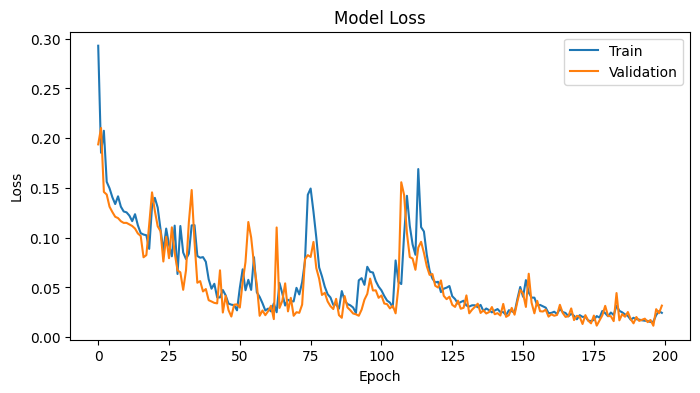

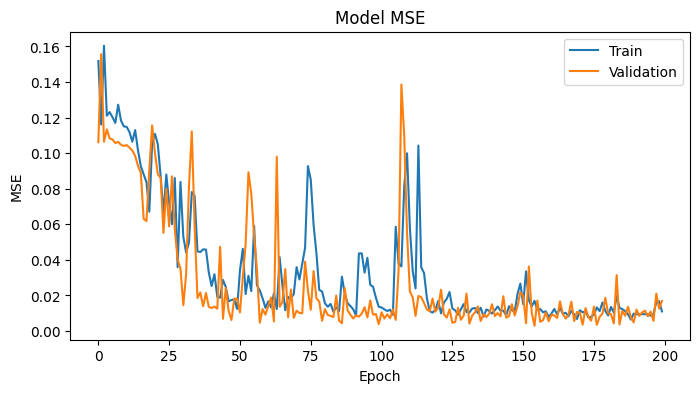

1/1 [==============================] - 1s 611ms/step
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_36 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_18 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_37 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 15ms/step - loss: 0.0338 - mse: 0.0208 - val_loss: 0.0282 - val_mse: 0.0146
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0213 - mse: 0.0083 - val_loss: 0.0249 - val_mse: 0.0131
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0226 - mse: 0.0119 - val_loss: 0.0138 - val_mse: 0.0039
Epoch 55/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0258 - mse: 0.0162 - val_loss: 0.0327 - val_mse: 0.0229
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0201 - mse: 0.0103 - val_loss: 0.0153 - val_mse: 0.0059
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0296 - mse: 0.0197 - val_loss: 0.0318 - val_mse: 0.0208
Epoch 58/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0319 - mse: 0.0207 - val_loss: 0.0603 - val_mse: 0.0496
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0303 

12/12 [==============================] - 0s 17ms/step - loss: 0.0110 - mse: 0.0040 - val_loss: 0.0170 - val_mse: 0.0104
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0117 - mse: 0.0053 - val_loss: 0.0089 - val_mse: 0.0028
Epoch 115/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0154 - mse: 0.0090 - val_loss: 0.0105 - val_mse: 0.0039
Epoch 116/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0155 - mse: 0.0090 - val_loss: 0.0135 - val_mse: 0.0063
Epoch 117/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0261 - mse: 0.0182 - val_loss: 0.0211 - val_mse: 0.0128
Epoch 118/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0257 - mse: 0.0174 - val_loss: 0.0261 - val_mse: 0.0173
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0306 - mse: 0.0203 - val_loss: 0.0167 - val_mse: 0.0036
Epoch 120/200
12/12 [==============================] - 0s 15ms/step - loss: 

12/12 [==============================] - 0s 18ms/step - loss: 0.0135 - mse: 0.0050 - val_loss: 0.0178 - val_mse: 0.0096
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0123 - mse: 0.0045 - val_loss: 0.0106 - val_mse: 0.0030
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0108 - mse: 0.0035 - val_loss: 0.0107 - val_mse: 0.0037
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0137 - mse: 0.0068 - val_loss: 0.0145 - val_mse: 0.0074
Epoch 178/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0138 - mse: 0.0062 - val_loss: 0.0132 - val_mse: 0.0051
Epoch 179/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0129 - mse: 0.0048 - val_loss: 0.0159 - val_mse: 0.0078
Epoch 180/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0134 - mse: 0.0055 - val_loss: 0.0127 - val_mse: 0.0050
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

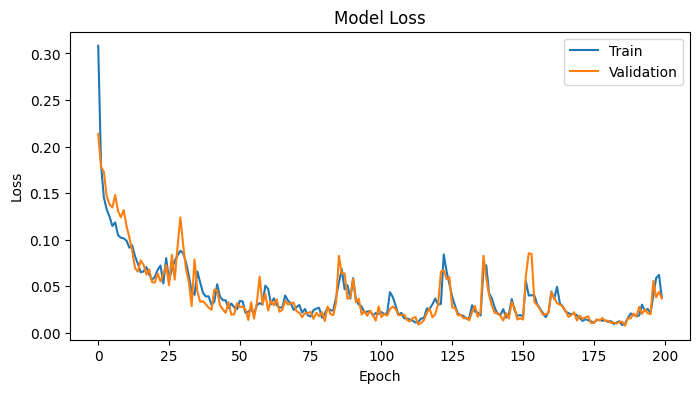

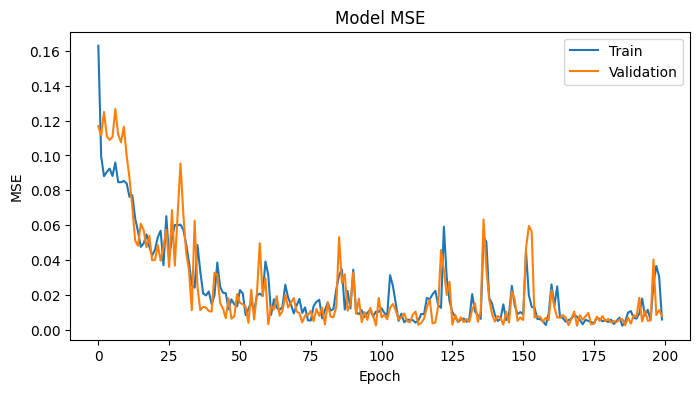

1/1 [==============================] - 1s 615ms/step
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_38 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_19 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_39 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 15ms/step - loss: 0.0801 - mse: 0.0609 - val_loss: 0.0777 - val_mse: 0.0577
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0945 - mse: 0.0726 - val_loss: 0.0887 - val_mse: 0.0649
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0700 - mse: 0.0454 - val_loss: 0.0697 - val_mse: 0.0450
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0975 - mse: 0.0734 - val_loss: 0.0742 - val_mse: 0.0503
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0809 - mse: 0.0574 - val_loss: 0.0925 - val_mse: 0.0704
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0717 - mse: 0.0507 - val_loss: 0.0745 - val_mse: 0.0549
Epoch 58/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0643 - mse: 0.0453 - val_loss: 0.0965 - val_mse: 0.0780
Epoch 59/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0731 

12/12 [==============================] - 0s 16ms/step - loss: 0.0711 - mse: 0.0554 - val_loss: 0.0461 - val_mse: 0.0293
Epoch 114/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0589 - mse: 0.0414 - val_loss: 0.0703 - val_mse: 0.0526
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0513 - mse: 0.0335 - val_loss: 0.0520 - val_mse: 0.0341
Epoch 116/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0392 - mse: 0.0210 - val_loss: 0.1232 - val_mse: 0.1052
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0579 - mse: 0.0401 - val_loss: 0.0643 - val_mse: 0.0456
Epoch 118/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0538 - mse: 0.0343 - val_loss: 0.0903 - val_mse: 0.0707
Epoch 119/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0512 - mse: 0.0320 - val_loss: 0.0707 - val_mse: 0.0518
Epoch 120/200
12/12 [==============================] - 0s 16ms/step - loss: 

12/12 [==============================] - 0s 14ms/step - loss: 0.0579 - mse: 0.0375 - val_loss: 0.0751 - val_mse: 0.0528
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0739 - mse: 0.0511 - val_loss: 0.1133 - val_mse: 0.0900
Epoch 176/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0562 - mse: 0.0318 - val_loss: 0.0665 - val_mse: 0.0420
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0598 - mse: 0.0362 - val_loss: 0.1443 - val_mse: 0.1209
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0771 - mse: 0.0533 - val_loss: 0.1590 - val_mse: 0.1350
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0680 - mse: 0.0438 - val_loss: 0.0963 - val_mse: 0.0725
Epoch 180/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0569 - mse: 0.0336 - val_loss: 0.1739 - val_mse: 0.1510
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

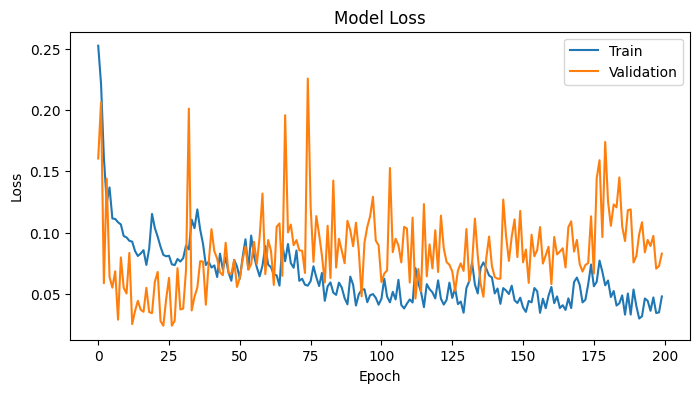

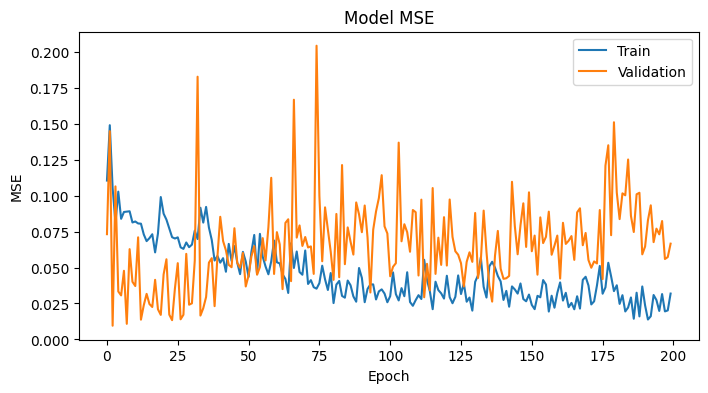

1/1 [==============================] - 1s 567ms/step
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_40 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_20 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_41 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 16ms/step - loss: 0.0571 - mse: 0.0428 - val_loss: 0.0503 - val_mse: 0.0348
Epoch 53/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0524 - mse: 0.0361 - val_loss: 0.0606 - val_mse: 0.0442
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0515 - mse: 0.0341 - val_loss: 0.0908 - val_mse: 0.0731
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0677 - mse: 0.0505 - val_loss: 0.1319 - val_mse: 0.1141
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0747 - mse: 0.0553 - val_loss: 0.0637 - val_mse: 0.0422
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0536 - mse: 0.0310 - val_loss: 0.0704 - val_mse: 0.0470
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0696 - mse: 0.0467 - val_loss: 0.0875 - val_mse: 0.0641
Epoch 59/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0567 

12/12 [==============================] - 0s 15ms/step - loss: 0.0379 - mse: 0.0193 - val_loss: 0.0549 - val_mse: 0.0368
Epoch 114/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0250 - mse: 0.0073 - val_loss: 0.0487 - val_mse: 0.0317
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0301 - mse: 0.0140 - val_loss: 0.0379 - val_mse: 0.0228
Epoch 116/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0295 - mse: 0.0151 - val_loss: 0.0340 - val_mse: 0.0205
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0373 - mse: 0.0240 - val_loss: 0.0463 - val_mse: 0.0317
Epoch 118/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0347 - mse: 0.0183 - val_loss: 0.0768 - val_mse: 0.0587
Epoch 119/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0383 - mse: 0.0196 - val_loss: 0.0485 - val_mse: 0.0296
Epoch 120/200
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0416 - mse: 0.0244 - val_loss: 0.0604 - val_mse: 0.0421
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0397 - mse: 0.0223 - val_loss: 0.0430 - val_mse: 0.0267
Epoch 176/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0255 - mse: 0.0102 - val_loss: 0.0447 - val_mse: 0.0307
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0284 - mse: 0.0155 - val_loss: 0.0472 - val_mse: 0.0349
Epoch 178/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0276 - mse: 0.0157 - val_loss: 0.0350 - val_mse: 0.0235
Epoch 179/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0203 - mse: 0.0091 - val_loss: 0.0451 - val_mse: 0.0344
Epoch 180/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0227 - mse: 0.0125 - val_loss: 0.0441 - val_mse: 0.0345
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

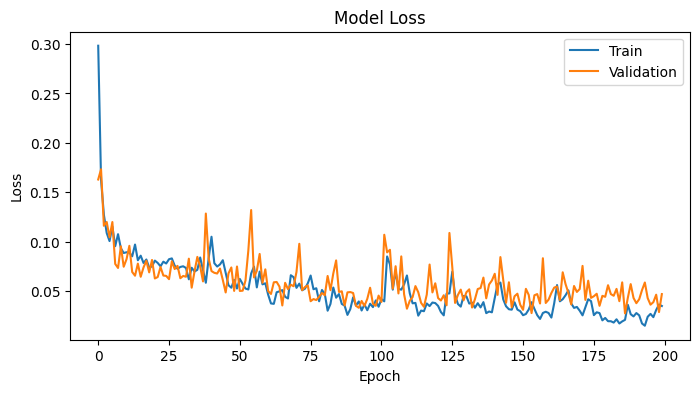

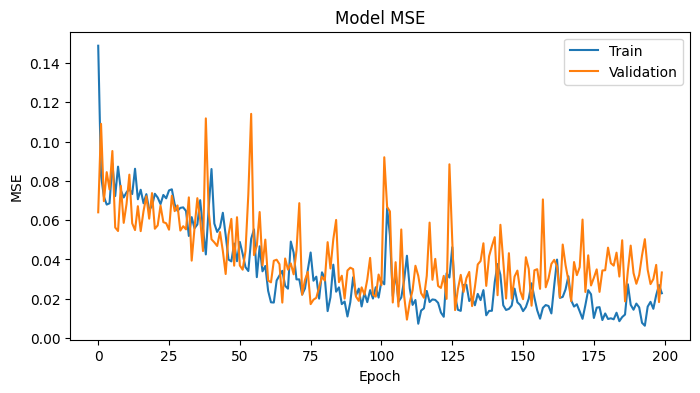

1/1 [==============================] - 1s 1s/step
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_42 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_21 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_43 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 3, 1)             65        
 stribut

12/12 [==============================] - 0s 16ms/step - loss: 0.0571 - mse: 0.0518 - val_loss: 0.1849 - val_mse: 0.1792
Epoch 53/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0544 - mse: 0.0489 - val_loss: 0.1530 - val_mse: 0.1476
Epoch 54/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0589 - mse: 0.0536 - val_loss: 0.1446 - val_mse: 0.1393
Epoch 55/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0712 - mse: 0.0655 - val_loss: 0.1490 - val_mse: 0.1427
Epoch 56/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0667 - mse: 0.0595 - val_loss: 0.1189 - val_mse: 0.1114
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0642 - mse: 0.0570 - val_loss: 0.1370 - val_mse: 0.1294
Epoch 58/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0644 - mse: 0.0558 - val_loss: 0.1454 - val_mse: 0.1336
Epoch 59/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0666 

12/12 [==============================] - 0s 15ms/step - loss: 0.0587 - mse: 0.0534 - val_loss: 0.1461 - val_mse: 0.1408
Epoch 114/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0587 - mse: 0.0533 - val_loss: 0.1760 - val_mse: 0.1706
Epoch 115/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0597 - mse: 0.0545 - val_loss: 0.1721 - val_mse: 0.1670
Epoch 116/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0606 - mse: 0.0553 - val_loss: 0.1537 - val_mse: 0.1483
Epoch 117/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0527 - mse: 0.0470 - val_loss: 0.1439 - val_mse: 0.1381
Epoch 118/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0502 - mse: 0.0447 - val_loss: 0.1813 - val_mse: 0.1759
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0532 - mse: 0.0478 - val_loss: 0.2041 - val_mse: 0.1990
Epoch 120/200
12/12 [==============================] - 0s 15ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0532 - mse: 0.0459 - val_loss: 0.1026 - val_mse: 0.0960
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0486 - mse: 0.0424 - val_loss: 0.1305 - val_mse: 0.1244
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0560 - mse: 0.0500 - val_loss: 0.1342 - val_mse: 0.1282
Epoch 177/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0616 - mse: 0.0552 - val_loss: 0.0995 - val_mse: 0.0925
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0601 - mse: 0.0531 - val_loss: 0.1665 - val_mse: 0.1595
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0558 - mse: 0.0490 - val_loss: 0.1792 - val_mse: 0.1723
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0503 - mse: 0.0434 - val_loss: 0.1954 - val_mse: 0.1888
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

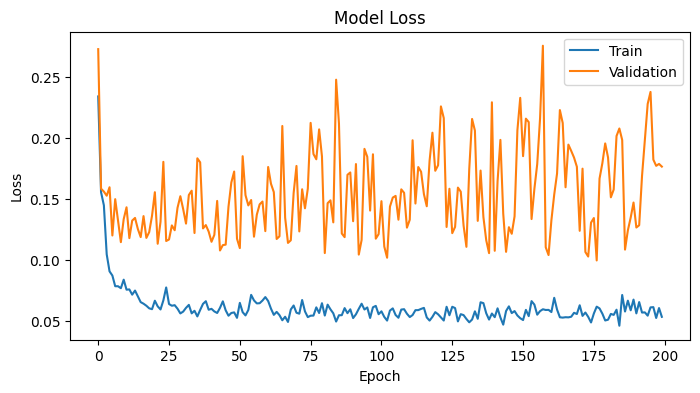

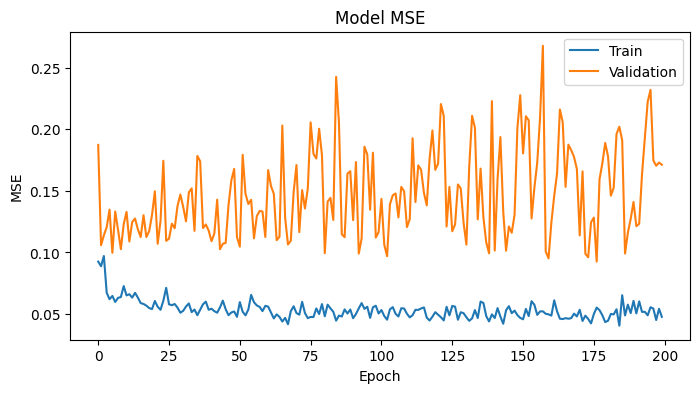

1/1 [==============================] - 1s 592ms/step
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_44 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_22 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_45 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 17ms/step - loss: 0.0522 - mse: 0.0474 - val_loss: 0.0900 - val_mse: 0.0851
Epoch 53/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0483 - mse: 0.0438 - val_loss: 0.1789 - val_mse: 0.1748
Epoch 54/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0556 - mse: 0.0516 - val_loss: 0.0905 - val_mse: 0.0866
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0496 - mse: 0.0458 - val_loss: 0.0932 - val_mse: 0.0892
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0570 - mse: 0.0528 - val_loss: 0.0913 - val_mse: 0.0872
Epoch 57/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0540 - mse: 0.0500 - val_loss: 0.1227 - val_mse: 0.1187
Epoch 58/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0544 - mse: 0.0506 - val_loss: 0.0906 - val_mse: 0.0871
Epoch 59/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0494 

12/12 [==============================] - 0s 19ms/step - loss: 0.0528 - mse: 0.0496 - val_loss: 0.1533 - val_mse: 0.1501
Epoch 114/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0525 - mse: 0.0494 - val_loss: 0.1193 - val_mse: 0.1163
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0475 - mse: 0.0446 - val_loss: 0.1470 - val_mse: 0.1441
Epoch 116/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0486 - mse: 0.0457 - val_loss: 0.1365 - val_mse: 0.1334
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0476 - mse: 0.0445 - val_loss: 0.1186 - val_mse: 0.1156
Epoch 118/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0584 - mse: 0.0555 - val_loss: 0.0996 - val_mse: 0.0968
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0461 - mse: 0.0431 - val_loss: 0.1252 - val_mse: 0.1219
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0438 - mse: 0.0360 - val_loss: 0.1180 - val_mse: 0.1103
Epoch 175/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0278 - mse: 0.0201 - val_loss: 0.1455 - val_mse: 0.1379
Epoch 176/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0386 - mse: 0.0307 - val_loss: 0.2293 - val_mse: 0.2202
Epoch 177/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0458 - mse: 0.0321 - val_loss: 0.1812 - val_mse: 0.1601
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0811 - mse: 0.0575 - val_loss: 0.1886 - val_mse: 0.1643
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0691 - mse: 0.0444 - val_loss: 0.1744 - val_mse: 0.1502
Epoch 180/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0528 - mse: 0.0309 - val_loss: 0.1383 - val_mse: 0.1190
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

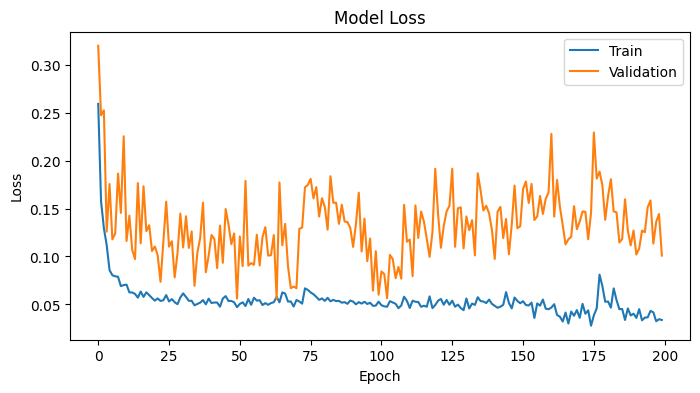

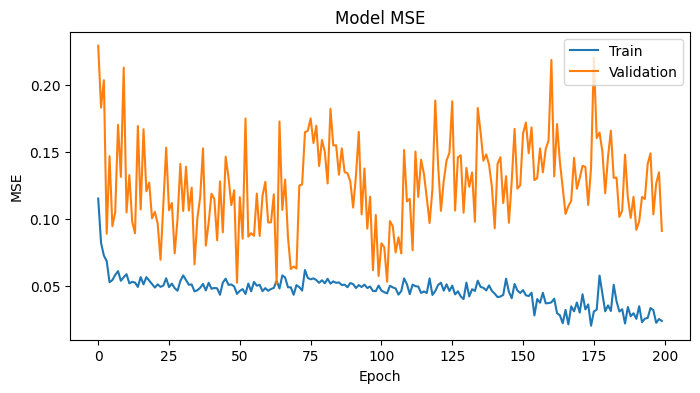

1/1 [==============================] - 1s 649ms/step
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_46 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_23 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_47 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 16ms/step - loss: 0.0182 - mse: 0.0068 - val_loss: 0.0164 - val_mse: 0.0061
Epoch 53/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0171 - mse: 0.0071 - val_loss: 0.0145 - val_mse: 0.0047
Epoch 54/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0205 - mse: 0.0105 - val_loss: 0.0162 - val_mse: 0.0056
Epoch 55/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0196 - mse: 0.0091 - val_loss: 0.0176 - val_mse: 0.0072
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0437 - mse: 0.0333 - val_loss: 0.0147 - val_mse: 0.0049
Epoch 57/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0732 - mse: 0.0561 - val_loss: 0.0837 - val_mse: 0.0553
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0777 - mse: 0.0421 - val_loss: 0.0519 - val_mse: 0.0106
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0801 

12/12 [==============================] - 0s 14ms/step - loss: 0.0215 - mse: 0.0031 - val_loss: 0.0245 - val_mse: 0.0065
Epoch 114/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0247 - mse: 0.0070 - val_loss: 0.0234 - val_mse: 0.0058
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0209 - mse: 0.0036 - val_loss: 0.0214 - val_mse: 0.0046
Epoch 116/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0220 - mse: 0.0053 - val_loss: 0.0201 - val_mse: 0.0037
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0203 - mse: 0.0041 - val_loss: 0.0219 - val_mse: 0.0061
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0193 - mse: 0.0037 - val_loss: 0.0219 - val_mse: 0.0063
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0269 - mse: 0.0114 - val_loss: 0.0254 - val_mse: 0.0096
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0234 - mse: 0.0027 - val_loss: 0.0230 - val_mse: 0.0037
Epoch 175/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0222 - mse: 0.0037 - val_loss: 0.0204 - val_mse: 0.0029
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0210 - mse: 0.0039 - val_loss: 0.0248 - val_mse: 0.0082
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0200 - mse: 0.0041 - val_loss: 0.0197 - val_mse: 0.0045
Epoch 178/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0178 - mse: 0.0031 - val_loss: 0.0214 - val_mse: 0.0073
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0181 - mse: 0.0044 - val_loss: 0.0176 - val_mse: 0.0045
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0310 - mse: 0.0182 - val_loss: 0.0172 - val_mse: 0.0039
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

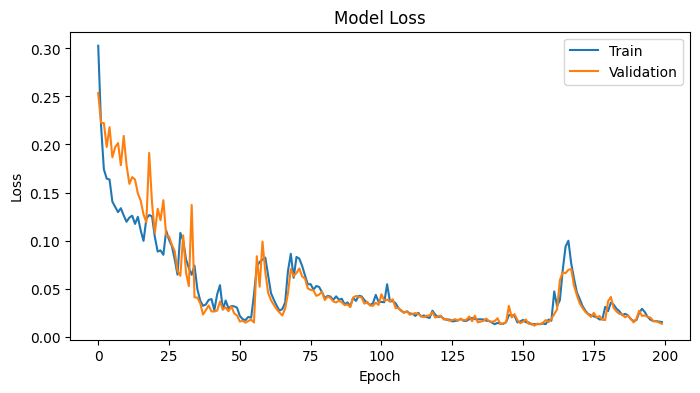

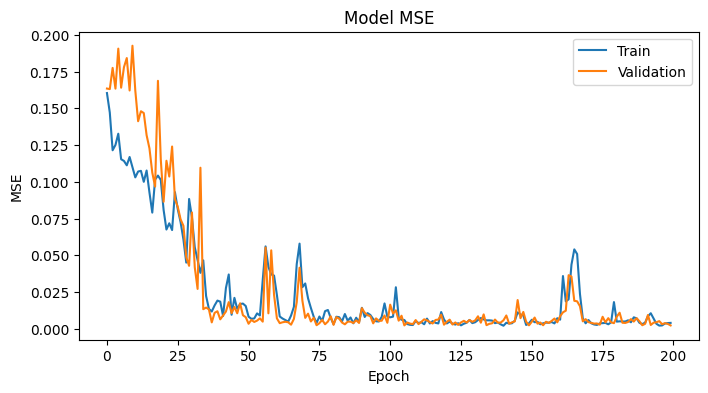

1/1 [==============================] - 1s 573ms/step
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_48 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_24 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_49 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 22ms/step - loss: 0.0185 - mse: 0.0052 - val_loss: 0.0188 - val_mse: 0.0065
Epoch 53/200
12/12 [==============================] - 0s 24ms/step - loss: 0.0186 - mse: 0.0071 - val_loss: 0.0181 - val_mse: 0.0072
Epoch 54/200
12/12 [==============================] - 0s 25ms/step - loss: 0.0168 - mse: 0.0064 - val_loss: 0.0116 - val_mse: 0.0019
Epoch 55/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0121 - mse: 0.0031 - val_loss: 0.0146 - val_mse: 0.0065
Epoch 56/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0131 - mse: 0.0055 - val_loss: 0.0152 - val_mse: 0.0078
Epoch 57/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0145 - mse: 0.0075 - val_loss: 0.0196 - val_mse: 0.0131
Epoch 58/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0132 - mse: 0.0069 - val_loss: 0.0129 - val_mse: 0.0065
Epoch 59/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0627 

12/12 [==============================] - 0s 33ms/step - loss: 0.0177 - mse: 0.0114 - val_loss: 0.0173 - val_mse: 0.0105
Epoch 114/200
12/12 [==============================] - 0s 25ms/step - loss: 0.0333 - mse: 0.0238 - val_loss: 0.0179 - val_mse: 0.0050
Epoch 115/200
12/12 [==============================] - 0s 26ms/step - loss: 0.0295 - mse: 0.0075 - val_loss: 0.0345 - val_mse: 0.0055
Epoch 116/200
12/12 [==============================] - 0s 32ms/step - loss: 0.0348 - mse: 0.0063 - val_loss: 0.0328 - val_mse: 0.0060
Epoch 117/200
12/12 [==============================] - 0s 40ms/step - loss: 0.0357 - mse: 0.0082 - val_loss: 0.0311 - val_mse: 0.0020
Epoch 118/200
12/12 [==============================] - 0s 43ms/step - loss: 0.0372 - mse: 0.0080 - val_loss: 0.0600 - val_mse: 0.0312
Epoch 119/200
12/12 [==============================] - 0s 31ms/step - loss: 0.0353 - mse: 0.0086 - val_loss: 0.0255 - val_mse: 0.0021
Epoch 120/200
12/12 [==============================] - 0s 25ms/step - loss: 

12/12 [==============================] - 0s 18ms/step - loss: 0.0285 - mse: 0.0052 - val_loss: 0.0272 - val_mse: 0.0053
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0235 - mse: 0.0028 - val_loss: 0.0238 - val_mse: 0.0046
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0236 - mse: 0.0050 - val_loss: 0.0222 - val_mse: 0.0042
Epoch 177/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0198 - mse: 0.0026 - val_loss: 0.0240 - val_mse: 0.0079
Epoch 178/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0199 - mse: 0.0046 - val_loss: 0.0168 - val_mse: 0.0022
Epoch 179/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0173 - mse: 0.0031 - val_loss: 0.0184 - val_mse: 0.0050
Epoch 180/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0162 - mse: 0.0032 - val_loss: 0.0160 - val_mse: 0.0036
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

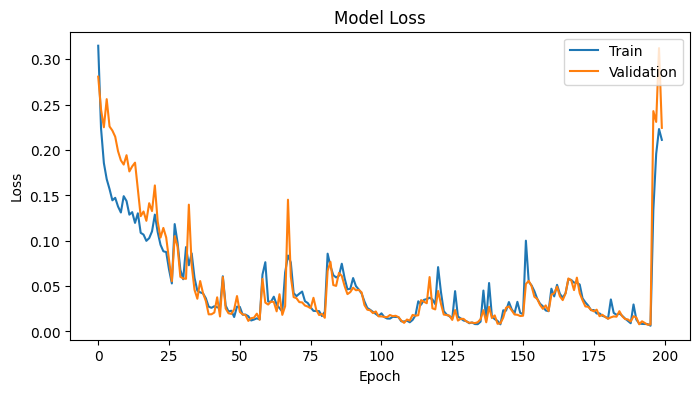

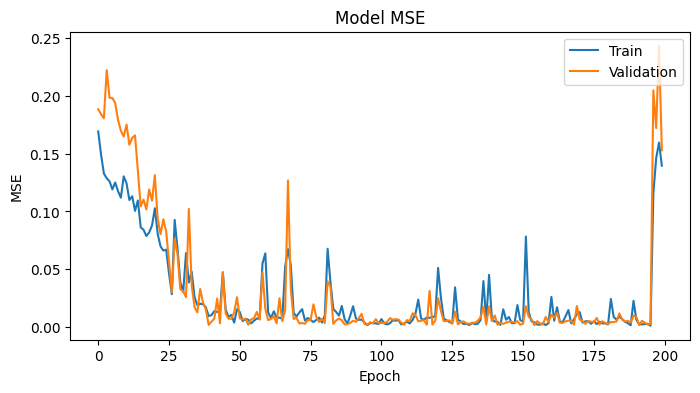

1/1 [==============================] - 1s 863ms/step
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_50 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_25 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_51 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 20ms/step - loss: 0.0389 - mse: 0.0176 - val_loss: 0.0424 - val_mse: 0.0232
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0284 - mse: 0.0099 - val_loss: 0.0341 - val_mse: 0.0168
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0306 - mse: 0.0140 - val_loss: 0.0500 - val_mse: 0.0341
Epoch 55/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0283 - mse: 0.0133 - val_loss: 0.0337 - val_mse: 0.0198
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0331 - mse: 0.0186 - val_loss: 0.0675 - val_mse: 0.0522
Epoch 57/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0286 - mse: 0.0121 - val_loss: 0.0798 - val_mse: 0.0601
Epoch 58/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0436 - mse: 0.0237 - val_loss: 0.0726 - val_mse: 0.0528
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0314 

12/12 [==============================] - 0s 20ms/step - loss: 0.0117 - mse: 0.0064 - val_loss: 0.0263 - val_mse: 0.0211
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0149 - mse: 0.0082 - val_loss: 0.0373 - val_mse: 0.0284
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0182 - mse: 0.0087 - val_loss: 0.0307 - val_mse: 0.0213
Epoch 116/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0193 - mse: 0.0097 - val_loss: 0.0259 - val_mse: 0.0168
Epoch 117/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0131 - mse: 0.0045 - val_loss: 0.0264 - val_mse: 0.0183
Epoch 118/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0141 - mse: 0.0065 - val_loss: 0.0238 - val_mse: 0.0164
Epoch 119/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0424 - mse: 0.0323 - val_loss: 0.0377 - val_mse: 0.0237
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0508 - mse: 0.0078 - val_loss: 0.0725 - val_mse: 0.0337
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0423 - mse: 0.0068 - val_loss: 0.0515 - val_mse: 0.0196
Epoch 176/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0343 - mse: 0.0048 - val_loss: 0.0489 - val_mse: 0.0217
Epoch 177/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0294 - mse: 0.0040 - val_loss: 0.0407 - val_mse: 0.0170
Epoch 178/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0265 - mse: 0.0041 - val_loss: 0.0434 - val_mse: 0.0223
Epoch 179/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0231 - mse: 0.0030 - val_loss: 0.0345 - val_mse: 0.0155
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0219 - mse: 0.0038 - val_loss: 0.0343 - val_mse: 0.0170
Epoch 181/200
12/12 [==============================] - 0s 14ms/step - loss: 

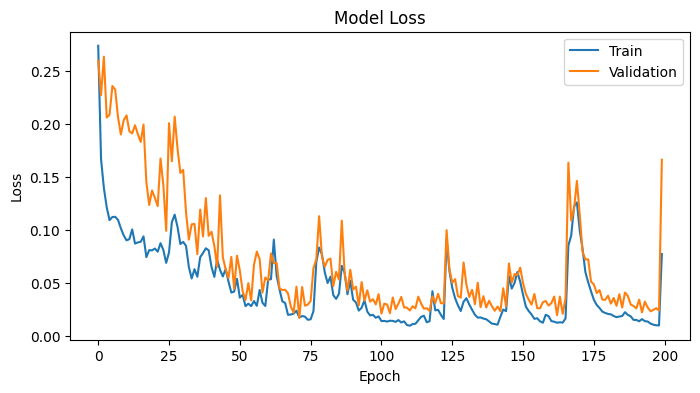

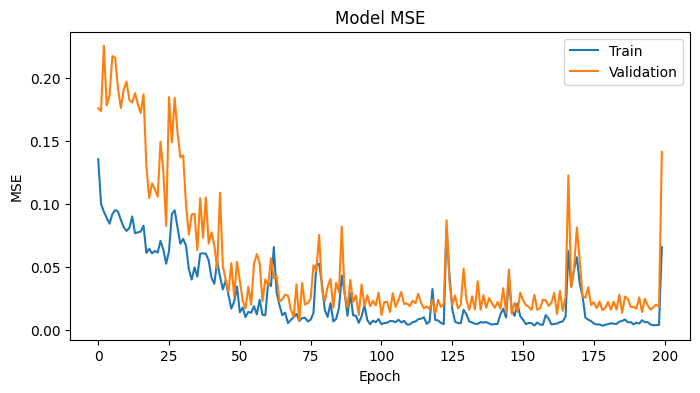

1/1 [==============================] - 1s 761ms/step
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_52 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_26 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_53 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 16ms/step - loss: 0.0139 - mse: 0.0065 - val_loss: 0.0169 - val_mse: 0.0095
Epoch 53/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0485 - mse: 0.0397 - val_loss: 0.0891 - val_mse: 0.0743
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0442 - mse: 0.0236 - val_loss: 0.0342 - val_mse: 0.0086
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0372 - mse: 0.0113 - val_loss: 0.0497 - val_mse: 0.0246
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0380 - mse: 0.0140 - val_loss: 0.0442 - val_mse: 0.0213
Epoch 57/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0368 - mse: 0.0142 - val_loss: 0.0503 - val_mse: 0.0280
Epoch 58/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0304 - mse: 0.0090 - val_loss: 0.0313 - val_mse: 0.0112
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0337 

12/12 [==============================] - 0s 13ms/step - loss: 0.0142 - mse: 0.0090 - val_loss: 0.0141 - val_mse: 0.0086
Epoch 114/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0106 - mse: 0.0048 - val_loss: 0.0167 - val_mse: 0.0109
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0356 - mse: 0.0277 - val_loss: 0.0356 - val_mse: 0.0243
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0220 - mse: 0.0091 - val_loss: 0.0265 - val_mse: 0.0128
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0280 - mse: 0.0134 - val_loss: 0.0456 - val_mse: 0.0296
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0324 - mse: 0.0157 - val_loss: 0.0328 - val_mse: 0.0164
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0214 - mse: 0.0055 - val_loss: 0.0284 - val_mse: 0.0135
Epoch 120/200
12/12 [==============================] - 0s 14ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0092 - mse: 0.0049 - val_loss: 0.0276 - val_mse: 0.0238
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0093 - mse: 0.0055 - val_loss: 0.0090 - val_mse: 0.0052
Epoch 176/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0100 - mse: 0.0062 - val_loss: 0.0290 - val_mse: 0.0252
Epoch 177/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0111 - mse: 0.0073 - val_loss: 0.0092 - val_mse: 0.0051
Epoch 178/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0077 - mse: 0.0038 - val_loss: 0.0178 - val_mse: 0.0141
Epoch 179/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0084 - mse: 0.0049 - val_loss: 0.0107 - val_mse: 0.0071
Epoch 180/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0101 - mse: 0.0062 - val_loss: 0.0234 - val_mse: 0.0193
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

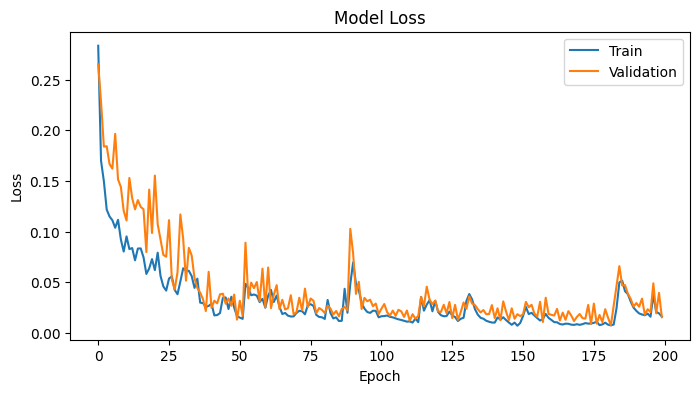

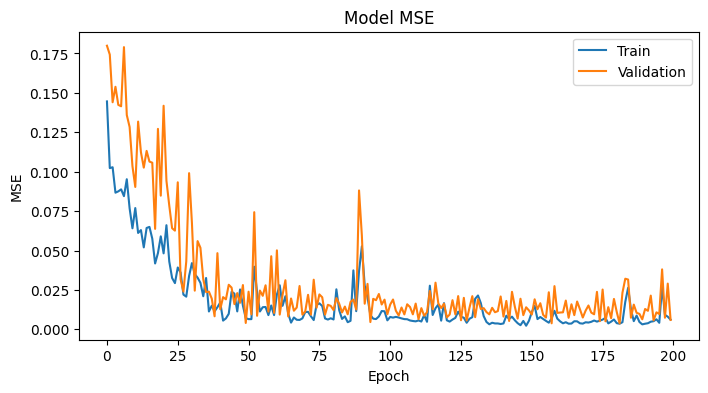

1/1 [==============================] - 1s 634ms/step
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_54 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_27 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_55 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 18ms/step - loss: 0.0642 - mse: 0.0357 - val_loss: 0.0542 - val_mse: 0.0199
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0496 - mse: 0.0139 - val_loss: 0.0572 - val_mse: 0.0215
Epoch 54/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0473 - mse: 0.0135 - val_loss: 0.0989 - val_mse: 0.0664
Epoch 55/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0685 - mse: 0.0365 - val_loss: 0.0488 - val_mse: 0.0177
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0491 - mse: 0.0198 - val_loss: 0.0518 - val_mse: 0.0254
Epoch 57/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0363 - mse: 0.0126 - val_loss: 0.0338 - val_mse: 0.0133
Epoch 58/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0344 - mse: 0.0147 - val_loss: 0.0292 - val_mse: 0.0103
Epoch 59/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0283 

12/12 [==============================] - 0s 17ms/step - loss: 0.0203 - mse: 0.0053 - val_loss: 0.0190 - val_mse: 0.0053
Epoch 114/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0237 - mse: 0.0107 - val_loss: 0.0201 - val_mse: 0.0073
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0198 - mse: 0.0069 - val_loss: 0.0224 - val_mse: 0.0096
Epoch 116/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0546 - mse: 0.0398 - val_loss: 0.0445 - val_mse: 0.0251
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0438 - mse: 0.0201 - val_loss: 0.0381 - val_mse: 0.0095
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0416 - mse: 0.0117 - val_loss: 0.0363 - val_mse: 0.0066
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0376 - mse: 0.0096 - val_loss: 0.0336 - val_mse: 0.0070
Epoch 120/200
12/12 [==============================] - 0s 16ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0907 - mse: 0.0206 - val_loss: 0.0997 - val_mse: 0.0322
Epoch 175/200
12/12 [==============================] - 0s 18ms/step - loss: 0.1576 - mse: 0.0876 - val_loss: 0.2782 - val_mse: 0.1889
Epoch 176/200
12/12 [==============================] - 0s 19ms/step - loss: 0.2243 - mse: 0.1224 - val_loss: 0.2793 - val_mse: 0.1697
Epoch 177/200
12/12 [==============================] - 0s 17ms/step - loss: 0.2250 - mse: 0.1174 - val_loss: 0.2849 - val_mse: 0.1829
Epoch 178/200
12/12 [==============================] - 0s 17ms/step - loss: 0.2121 - mse: 0.1158 - val_loss: 0.2646 - val_mse: 0.1746
Epoch 179/200
12/12 [==============================] - 0s 17ms/step - loss: 0.1975 - mse: 0.1111 - val_loss: 0.2413 - val_mse: 0.1607
Epoch 180/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1712 - mse: 0.0949 - val_loss: 0.2077 - val_mse: 0.1346
Epoch 181/200
12/12 [==============================] - 0s 13ms/step - loss: 

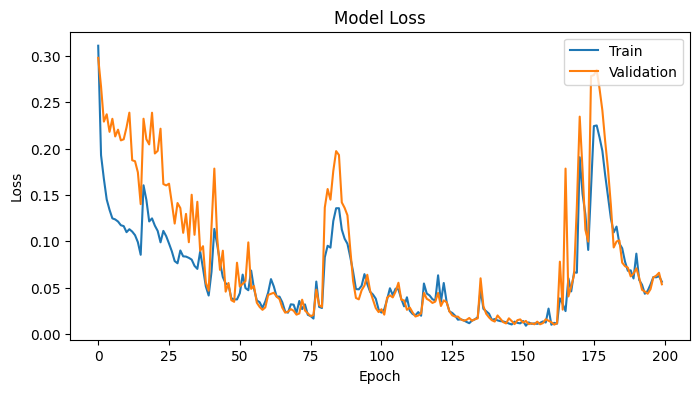

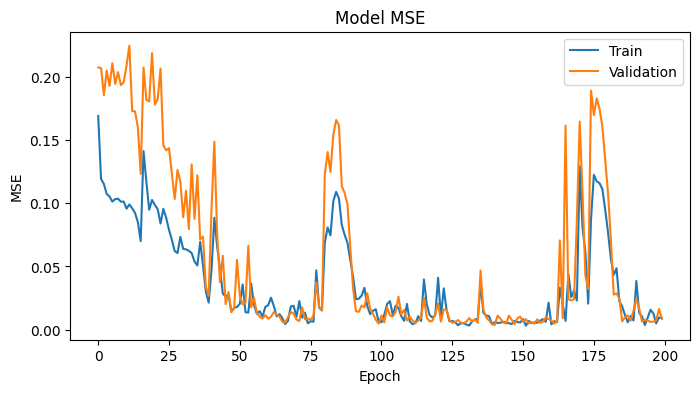

1/1 [==============================] - 1s 625ms/step
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_56 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_28 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_57 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 18ms/step - loss: 0.0295 - mse: 0.0136 - val_loss: 0.0597 - val_mse: 0.0454
Epoch 53/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0300 - mse: 0.0163 - val_loss: 0.0909 - val_mse: 0.0777
Epoch 54/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0286 - mse: 0.0155 - val_loss: 0.0562 - val_mse: 0.0432
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0195 - mse: 0.0070 - val_loss: 0.0574 - val_mse: 0.0458
Epoch 56/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0197 - mse: 0.0089 - val_loss: 0.0495 - val_mse: 0.0394
Epoch 57/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0188 - mse: 0.0089 - val_loss: 0.0495 - val_mse: 0.0397
Epoch 58/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0176 - mse: 0.0082 - val_loss: 0.0515 - val_mse: 0.0426
Epoch 59/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0172 

12/12 [==============================] - 0s 15ms/step - loss: 0.0172 - mse: 0.0091 - val_loss: 0.0419 - val_mse: 0.0340
Epoch 114/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0658 - mse: 0.0533 - val_loss: 0.2881 - val_mse: 0.2623
Epoch 115/200
12/12 [==============================] - 0s 15ms/step - loss: 0.1299 - mse: 0.0897 - val_loss: 0.2850 - val_mse: 0.2305
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.1428 - mse: 0.0813 - val_loss: 0.3198 - val_mse: 0.2524
Epoch 117/200
12/12 [==============================] - 0s 16ms/step - loss: 0.1411 - mse: 0.0747 - val_loss: 0.2647 - val_mse: 0.2018
Epoch 118/200
12/12 [==============================] - 0s 17ms/step - loss: 0.1196 - mse: 0.0623 - val_loss: 0.2365 - val_mse: 0.1866
Epoch 119/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0951 - mse: 0.0495 - val_loss: 0.1964 - val_mse: 0.1544
Epoch 120/200
12/12 [==============================] - 0s 15ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0176 - mse: 0.0076 - val_loss: 0.0425 - val_mse: 0.0326
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0202 - mse: 0.0102 - val_loss: 0.0480 - val_mse: 0.0378
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0173 - mse: 0.0067 - val_loss: 0.0500 - val_mse: 0.0396
Epoch 177/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0181 - mse: 0.0079 - val_loss: 0.0426 - val_mse: 0.0330
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0130 - mse: 0.0039 - val_loss: 0.0527 - val_mse: 0.0441
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0190 - mse: 0.0103 - val_loss: 0.0368 - val_mse: 0.0258
Epoch 180/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0282 - mse: 0.0119 - val_loss: 0.0407 - val_mse: 0.0218
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

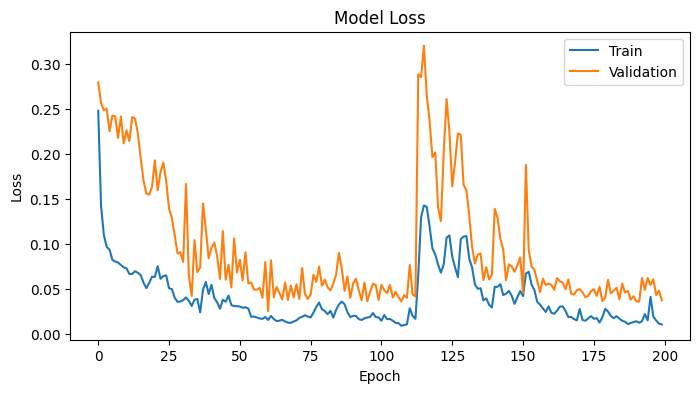

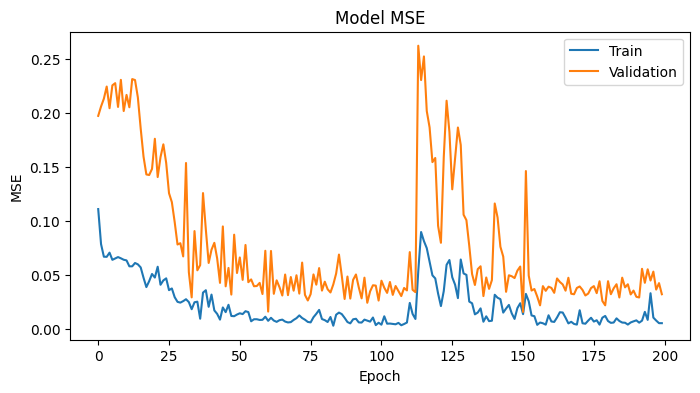

1/1 [==============================] - 1s 745ms/step
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_58 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_29 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_59 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 19ms/step - loss: 0.0657 - mse: 0.0389 - val_loss: 0.0545 - val_mse: 0.0277
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0576 - mse: 0.0314 - val_loss: 0.0417 - val_mse: 0.0162
Epoch 54/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0530 - mse: 0.0274 - val_loss: 0.0562 - val_mse: 0.0298
Epoch 55/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0470 - mse: 0.0193 - val_loss: 0.0732 - val_mse: 0.0415
Epoch 56/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0854 - mse: 0.0543 - val_loss: 0.0438 - val_mse: 0.0123
Epoch 57/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0443 - mse: 0.0141 - val_loss: 0.0318 - val_mse: 0.0042
Epoch 58/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0327 - mse: 0.0080 - val_loss: 0.0365 - val_mse: 0.0152
Epoch 59/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0290 

12/12 [==============================] - 0s 18ms/step - loss: 0.0139 - mse: 0.0049 - val_loss: 0.0343 - val_mse: 0.0258
Epoch 114/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0158 - mse: 0.0077 - val_loss: 0.0154 - val_mse: 0.0076
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0129 - mse: 0.0049 - val_loss: 0.0155 - val_mse: 0.0075
Epoch 116/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0351 - mse: 0.0264 - val_loss: 0.0934 - val_mse: 0.0807
Epoch 117/200
12/12 [==============================] - 0s 14ms/step - loss: 0.0805 - mse: 0.0638 - val_loss: 0.0861 - val_mse: 0.0659
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0519 - mse: 0.0307 - val_loss: 0.0529 - val_mse: 0.0312
Epoch 119/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0389 - mse: 0.0174 - val_loss: 0.0310 - val_mse: 0.0097
Epoch 120/200
12/12 [==============================] - 0s 15ms/step - loss: 

12/12 [==============================] - 0s 18ms/step - loss: 0.0179 - mse: 0.0078 - val_loss: 0.0194 - val_mse: 0.0089
Epoch 175/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0218 - mse: 0.0113 - val_loss: 0.0238 - val_mse: 0.0120
Epoch 176/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0210 - mse: 0.0078 - val_loss: 0.0310 - val_mse: 0.0167
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0216 - mse: 0.0069 - val_loss: 0.0224 - val_mse: 0.0071
Epoch 178/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0195 - mse: 0.0046 - val_loss: 0.0259 - val_mse: 0.0121
Epoch 179/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0169 - mse: 0.0042 - val_loss: 0.0174 - val_mse: 0.0059
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0148 - mse: 0.0043 - val_loss: 0.0218 - val_mse: 0.0123
Epoch 181/200
12/12 [==============================] - 0s 18ms/step - loss: 

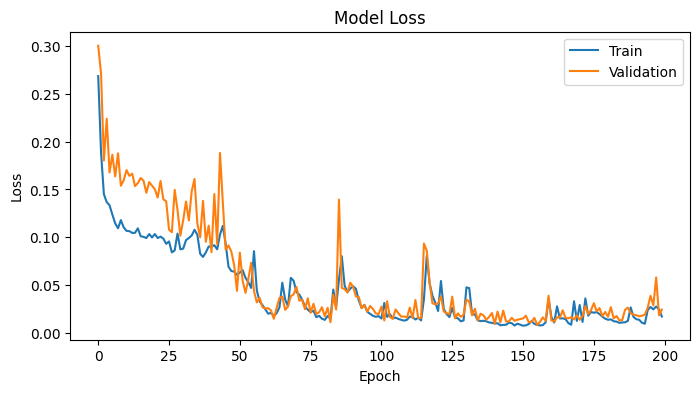

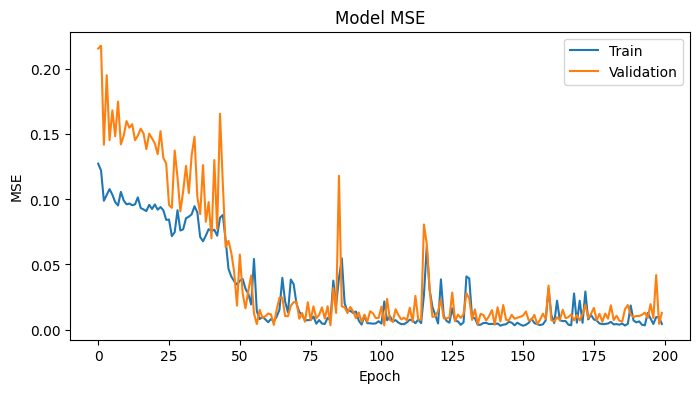

1/1 [==============================] - 1s 610ms/step
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_60 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_30 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_61 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 16ms/step - loss: 0.1149 - mse: 0.0901 - val_loss: 0.0917 - val_mse: 0.0636
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0744 - mse: 0.0429 - val_loss: 0.0761 - val_mse: 0.0426
Epoch 54/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0712 - mse: 0.0392 - val_loss: 0.0394 - val_mse: 0.0102
Epoch 55/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0483 - mse: 0.0212 - val_loss: 0.0320 - val_mse: 0.0077
Epoch 56/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0429 - mse: 0.0206 - val_loss: 0.0272 - val_mse: 0.0067
Epoch 57/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0430 - mse: 0.0232 - val_loss: 0.0397 - val_mse: 0.0208
Epoch 58/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0478 - mse: 0.0290 - val_loss: 0.0225 - val_mse: 0.0050
Epoch 59/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0374 

12/12 [==============================] - 0s 18ms/step - loss: 0.0363 - mse: 0.0157 - val_loss: 0.0287 - val_mse: 0.0078
Epoch 114/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0411 - mse: 0.0208 - val_loss: 0.0366 - val_mse: 0.0171
Epoch 115/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0348 - mse: 0.0156 - val_loss: 0.0257 - val_mse: 0.0067
Epoch 116/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0325 - mse: 0.0140 - val_loss: 0.0239 - val_mse: 0.0061
Epoch 117/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0366 - mse: 0.0191 - val_loss: 0.0203 - val_mse: 0.0035
Epoch 118/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0311 - mse: 0.0139 - val_loss: 0.0282 - val_mse: 0.0108
Epoch 119/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0373 - mse: 0.0197 - val_loss: 0.0248 - val_mse: 0.0074
Epoch 120/200
12/12 [==============================] - 0s 24ms/step - loss: 

12/12 [==============================] - 0s 15ms/step - loss: 0.0687 - mse: 0.0398 - val_loss: 0.0823 - val_mse: 0.0543
Epoch 175/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0557 - mse: 0.0283 - val_loss: 0.0383 - val_mse: 0.0119
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0376 - mse: 0.0124 - val_loss: 0.0314 - val_mse: 0.0075
Epoch 177/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0354 - mse: 0.0127 - val_loss: 0.0243 - val_mse: 0.0028
Epoch 178/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0307 - mse: 0.0100 - val_loss: 0.0263 - val_mse: 0.0064
Epoch 179/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0377 - mse: 0.0182 - val_loss: 0.0378 - val_mse: 0.0183
Epoch 180/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0424 - mse: 0.0226 - val_loss: 0.0251 - val_mse: 0.0050
Epoch 181/200
12/12 [==============================] - 0s 15ms/step - loss: 

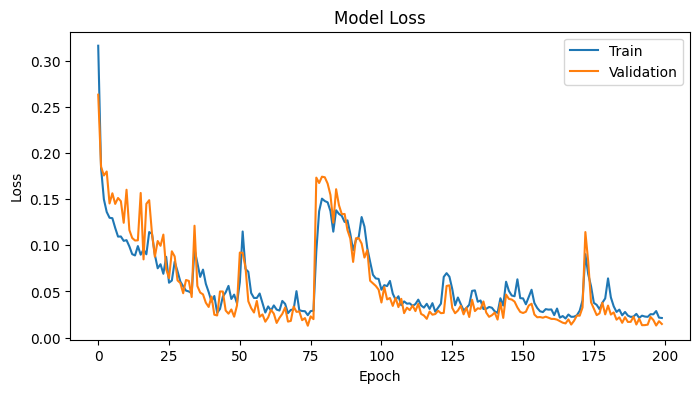

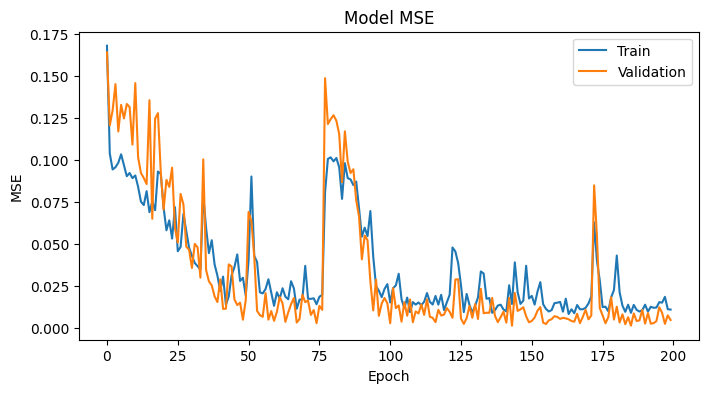

1/1 [==============================] - 1s 808ms/step
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_62 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_31 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_63 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 27ms/step - loss: 0.0235 - mse: 0.0115 - val_loss: 0.0222 - val_mse: 0.0111
Epoch 53/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0220 - mse: 0.0108 - val_loss: 0.0178 - val_mse: 0.0063
Epoch 54/200
12/12 [==============================] - 0s 24ms/step - loss: 0.0227 - mse: 0.0115 - val_loss: 0.0164 - val_mse: 0.0055
Epoch 55/200
12/12 [==============================] - 0s 25ms/step - loss: 0.0220 - mse: 0.0115 - val_loss: 0.0157 - val_mse: 0.0057
Epoch 56/200
12/12 [==============================] - 0s 25ms/step - loss: 0.0173 - mse: 0.0064 - val_loss: 0.0161 - val_mse: 0.0048
Epoch 57/200
12/12 [==============================] - 0s 32ms/step - loss: 0.0212 - mse: 0.0100 - val_loss: 0.0181 - val_mse: 0.0071
Epoch 58/200
12/12 [==============================] - 0s 23ms/step - loss: 0.0213 - mse: 0.0107 - val_loss: 0.0227 - val_mse: 0.0127
Epoch 59/200
12/12 [==============================] - 0s 32ms/step - loss: 0.0316 

12/12 [==============================] - 0s 19ms/step - loss: 0.0369 - mse: 0.0042 - val_loss: 0.0362 - val_mse: 0.0055
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0355 - mse: 0.0065 - val_loss: 0.0319 - val_mse: 0.0044
Epoch 115/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0319 - mse: 0.0050 - val_loss: 0.0273 - val_mse: 0.0013
Epoch 116/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0630 - mse: 0.0371 - val_loss: 0.0429 - val_mse: 0.0145
Epoch 117/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0399 - mse: 0.0086 - val_loss: 0.0412 - val_mse: 0.0080
Epoch 118/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0414 - mse: 0.0084 - val_loss: 0.0367 - val_mse: 0.0046
Epoch 119/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0366 - mse: 0.0056 - val_loss: 0.0331 - val_mse: 0.0036
Epoch 120/200
12/12 [==============================] - 0s 23ms/step - loss: 

12/12 [==============================] - 0s 19ms/step - loss: 0.0110 - mse: 0.0037 - val_loss: 0.0091 - val_mse: 0.0016
Epoch 175/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0122 - mse: 0.0049 - val_loss: 0.0097 - val_mse: 0.0025
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0210 - mse: 0.0126 - val_loss: 0.0199 - val_mse: 0.0096
Epoch 177/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0193 - mse: 0.0083 - val_loss: 0.0173 - val_mse: 0.0061
Epoch 178/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0154 - mse: 0.0047 - val_loss: 0.0186 - val_mse: 0.0085
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0140 - mse: 0.0045 - val_loss: 0.0138 - val_mse: 0.0050
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0124 - mse: 0.0043 - val_loss: 0.0116 - val_mse: 0.0040
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

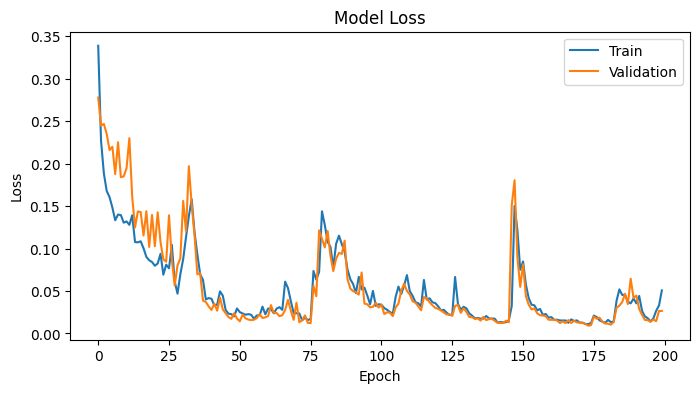

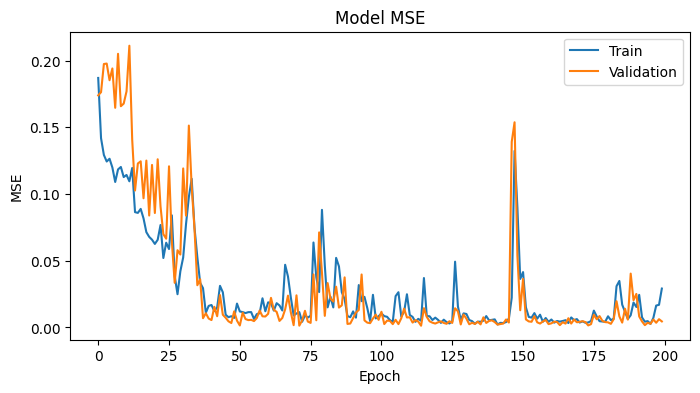

1/1 [==============================] - 1s 828ms/step
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_64 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_32 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_65 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 18ms/step - loss: 0.1015 - mse: 0.0833 - val_loss: 0.0539 - val_mse: 0.0333
Epoch 53/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0941 - mse: 0.0717 - val_loss: 0.0397 - val_mse: 0.0150
Epoch 54/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0489 - mse: 0.0237 - val_loss: 0.0399 - val_mse: 0.0150
Epoch 55/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0406 - mse: 0.0158 - val_loss: 0.0477 - val_mse: 0.0238
Epoch 56/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0385 - mse: 0.0164 - val_loss: 0.0436 - val_mse: 0.0232
Epoch 57/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0337 - mse: 0.0142 - val_loss: 0.0347 - val_mse: 0.0165
Epoch 58/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0312 - mse: 0.0140 - val_loss: 0.0380 - val_mse: 0.0221
Epoch 59/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0233 

12/12 [==============================] - 0s 19ms/step - loss: 0.0670 - mse: 0.0490 - val_loss: 0.0324 - val_mse: 0.0131
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0347 - mse: 0.0150 - val_loss: 0.0366 - val_mse: 0.0165
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0300 - mse: 0.0099 - val_loss: 0.0371 - val_mse: 0.0171
Epoch 116/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0271 - mse: 0.0077 - val_loss: 0.0369 - val_mse: 0.0182
Epoch 117/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0350 - mse: 0.0165 - val_loss: 0.0295 - val_mse: 0.0112
Epoch 118/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0278 - mse: 0.0099 - val_loss: 0.0293 - val_mse: 0.0120
Epoch 119/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0281 - mse: 0.0110 - val_loss: 0.0339 - val_mse: 0.0167
Epoch 120/200
12/12 [==============================] - 0s 16ms/step - loss: 

12/12 [==============================] - 0s 19ms/step - loss: 0.1013 - mse: 0.0478 - val_loss: 0.0843 - val_mse: 0.0265
Epoch 175/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0968 - mse: 0.0362 - val_loss: 0.0732 - val_mse: 0.0107
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0857 - mse: 0.0240 - val_loss: 0.0756 - val_mse: 0.0180
Epoch 177/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0675 - mse: 0.0150 - val_loss: 0.0568 - val_mse: 0.0095
Epoch 178/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0586 - mse: 0.0141 - val_loss: 0.0484 - val_mse: 0.0063
Epoch 179/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0499 - mse: 0.0093 - val_loss: 0.0560 - val_mse: 0.0172
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0487 - mse: 0.0115 - val_loss: 0.0420 - val_mse: 0.0068
Epoch 181/200
12/12 [==============================] - 0s 18ms/step - loss: 

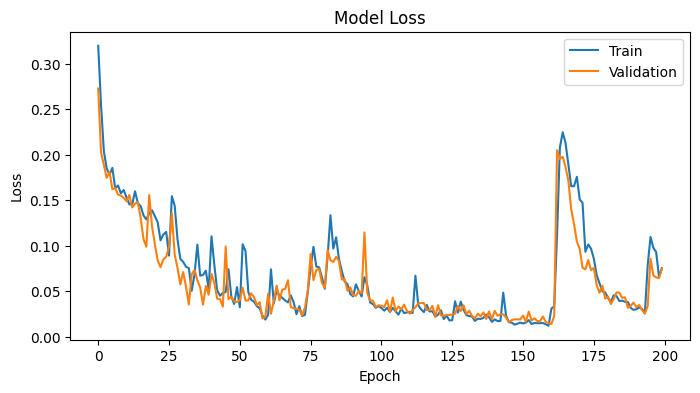

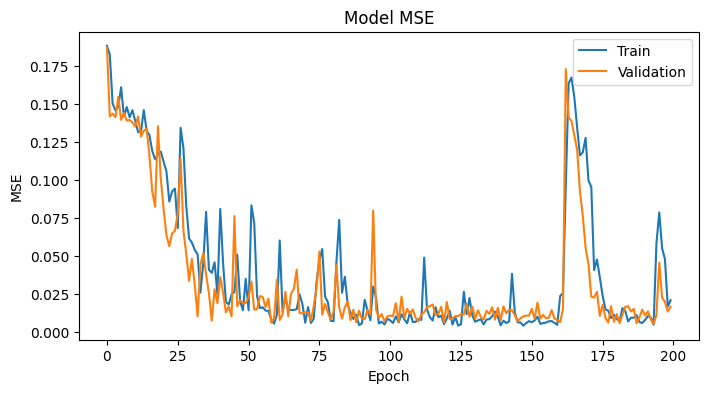

1/1 [==============================] - 1s 672ms/step
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_66 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_33 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_67 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 18ms/step - loss: 0.0532 - mse: 0.0251 - val_loss: 0.0434 - val_mse: 0.0167
Epoch 53/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0517 - mse: 0.0247 - val_loss: 0.0394 - val_mse: 0.0125
Epoch 54/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0497 - mse: 0.0235 - val_loss: 0.0394 - val_mse: 0.0141
Epoch 55/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0586 - mse: 0.0340 - val_loss: 0.0919 - val_mse: 0.0677
Epoch 56/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0535 - mse: 0.0295 - val_loss: 0.0428 - val_mse: 0.0190
Epoch 57/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0850 - mse: 0.0604 - val_loss: 0.0389 - val_mse: 0.0140
Epoch 58/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0770 - mse: 0.0507 - val_loss: 0.0632 - val_mse: 0.0299
Epoch 59/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0744 

12/12 [==============================] - 0s 19ms/step - loss: 0.0363 - mse: 0.0114 - val_loss: 0.0319 - val_mse: 0.0083
Epoch 114/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0322 - mse: 0.0097 - val_loss: 0.0307 - val_mse: 0.0093
Epoch 115/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0304 - mse: 0.0100 - val_loss: 0.0283 - val_mse: 0.0089
Epoch 116/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0250 - mse: 0.0064 - val_loss: 0.0241 - val_mse: 0.0064
Epoch 117/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0250 - mse: 0.0080 - val_loss: 0.0287 - val_mse: 0.0125
Epoch 118/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0222 - mse: 0.0066 - val_loss: 0.0204 - val_mse: 0.0054
Epoch 119/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0222 - mse: 0.0075 - val_loss: 0.0260 - val_mse: 0.0116
Epoch 120/200
12/12 [==============================] - 0s 17ms/step - loss: 

12/12 [==============================] - 0s 19ms/step - loss: 0.0178 - mse: 0.0092 - val_loss: 0.0177 - val_mse: 0.0094
Epoch 175/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0153 - mse: 0.0071 - val_loss: 0.0135 - val_mse: 0.0054
Epoch 176/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0184 - mse: 0.0102 - val_loss: 0.0179 - val_mse: 0.0093
Epoch 177/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0179 - mse: 0.0091 - val_loss: 0.0157 - val_mse: 0.0070
Epoch 178/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0157 - mse: 0.0069 - val_loss: 0.0179 - val_mse: 0.0093
Epoch 179/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0148 - mse: 0.0065 - val_loss: 0.0169 - val_mse: 0.0088
Epoch 180/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0177 - mse: 0.0100 - val_loss: 0.0127 - val_mse: 0.0050
Epoch 181/200
12/12 [==============================] - 0s 16ms/step - loss: 

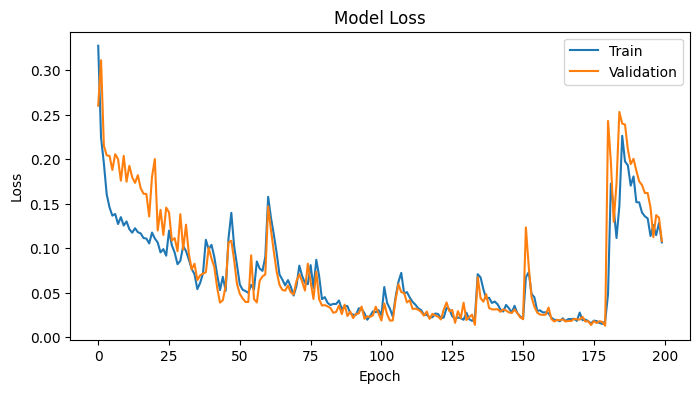

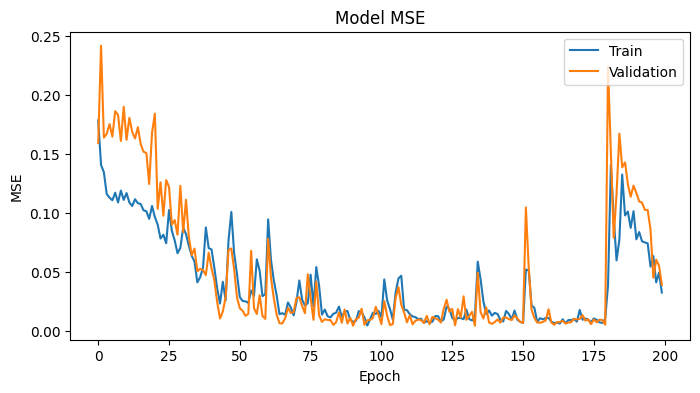

1/1 [==============================] - 1s 632ms/step
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 9, 10)]           0         
                                                                 
 bidirectional_68 (Bidirecti  (None, 64)               11008     
 onal)                                                           
                                                                 
 repeat_vector_34 (RepeatVec  (None, 3, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_69 (Bidirecti  (None, 3, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 3, 1)             65        
 stri

12/12 [==============================] - 0s 17ms/step - loss: 0.0357 - mse: 0.0169 - val_loss: 0.0259 - val_mse: 0.0088
Epoch 53/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0304 - mse: 0.0142 - val_loss: 0.0264 - val_mse: 0.0119
Epoch 54/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0330 - mse: 0.0192 - val_loss: 0.0300 - val_mse: 0.0170
Epoch 55/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0257 - mse: 0.0130 - val_loss: 0.0186 - val_mse: 0.0063
Epoch 56/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0216 - mse: 0.0093 - val_loss: 0.0315 - val_mse: 0.0200
Epoch 57/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0252 - mse: 0.0130 - val_loss: 0.0192 - val_mse: 0.0057
Epoch 58/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0402 - mse: 0.0265 - val_loss: 0.0292 - val_mse: 0.0145
Epoch 59/200
12/12 [==============================] - 0s 16ms/step - loss: 0.0282 

12/12 [==============================] - 0s 18ms/step - loss: 0.0587 - mse: 0.0259 - val_loss: 0.0422 - val_mse: 0.0100
Epoch 114/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0459 - mse: 0.0150 - val_loss: 0.0502 - val_mse: 0.0210
Epoch 115/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0399 - mse: 0.0123 - val_loss: 0.0335 - val_mse: 0.0073
Epoch 116/200
12/12 [==============================] - 0s 19ms/step - loss: 0.0332 - mse: 0.0087 - val_loss: 0.0292 - val_mse: 0.0067
Epoch 117/200
12/12 [==============================] - 0s 20ms/step - loss: 0.0265 - mse: 0.0051 - val_loss: 0.0267 - val_mse: 0.0066
Epoch 118/200
12/12 [==============================] - 0s 21ms/step - loss: 0.0255 - mse: 0.0063 - val_loss: 0.0238 - val_mse: 0.0055
Epoch 119/200
12/12 [==============================] - 0s 24ms/step - loss: 0.0239 - mse: 0.0065 - val_loss: 0.0219 - val_mse: 0.0053
Epoch 120/200
12/12 [==============================] - 0s 22ms/step - loss: 

12/12 [==============================] - 0s 17ms/step - loss: 0.0133 - mse: 0.0055 - val_loss: 0.0125 - val_mse: 0.0051
Epoch 175/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0185 - mse: 0.0114 - val_loss: 0.0128 - val_mse: 0.0055
Epoch 176/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0298 - mse: 0.0182 - val_loss: 0.0298 - val_mse: 0.0115
Epoch 177/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0502 - mse: 0.0244 - val_loss: 0.0529 - val_mse: 0.0168
Epoch 178/200
12/12 [==============================] - 0s 18ms/step - loss: 0.0514 - mse: 0.0107 - val_loss: 0.0508 - val_mse: 0.0084
Epoch 179/200
12/12 [==============================] - 0s 15ms/step - loss: 0.0867 - mse: 0.0456 - val_loss: 0.0557 - val_mse: 0.0168
Epoch 180/200
12/12 [==============================] - 0s 17ms/step - loss: 0.0458 - mse: 0.0095 - val_loss: 0.0437 - val_mse: 0.0109
Epoch 181/200
12/12 [==============================] - 0s 17ms/step - loss: 

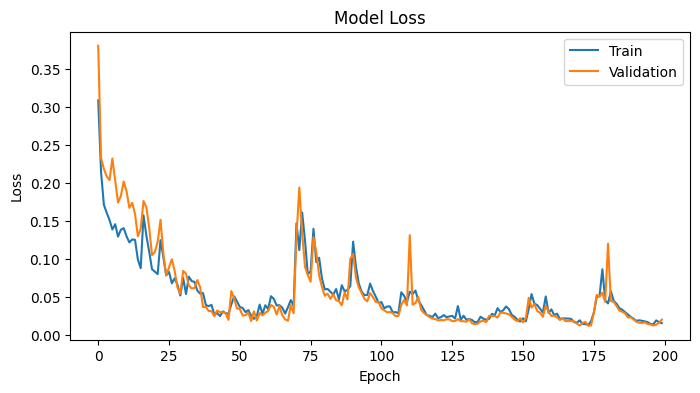

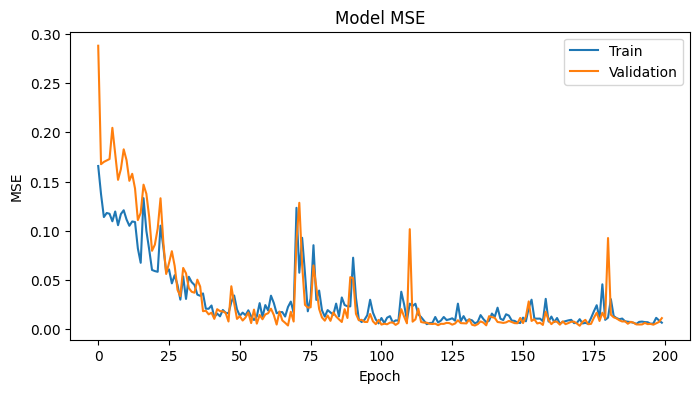

1/1 [==============================] - 1s 685ms/step


In [7]:
for indx,row in crma_grp.iterrows():
    crma_sel_instLst = row['InstitutionID']
    all_paymnt_df_sel = all_paymnt_df[all_paymnt_df['InstitutionID'].isin(crma_sel_instLst)]    
    all_paymnt_df_sel_grp = all_paymnt_df_sel.groupby(['PmtYear','PmtQuarter']).agg({
                                                         'InstitutionID': lambda x: list(x), 
                                                         'BilledStudentsPmt1':'sum'
                                                        }).reset_index() 
    
    segment_key = row['InstitutionTypeName'] + '_'+  row['SchoolType']+ '_'+  row['ProgramType'] + '_' + row['Region']
    
    if len(all_paymnt_df_sel_grp)==30 : 
        df_bl_ts_reg=all_paymnt_df_sel_grp.merge(teas_reg_grp, left_on=['PmtYear', 'PmtQuarter'], 
                                             right_on=['Year', 'Quarter']).drop(['PmtYear','PmtQuarter','InstitutionID'],axis=1)
        
        df_bl_ts_reg_test=teas_test_df_grp.merge(df_bl_ts_reg,on = ['Year', 'Quarter']) 
        df = df_bl_ts_reg_test.copy()
        df=df[:-1]
        
        df.to_csv(segment_data_path + segment_key + '.csv')
        
        ### generate features ###
        feature_df = feature_generator.generate_lags(df)
        feature_df = feature_generator.generate_rolling_mean(feature_df)
        feature_df = feature_generator.generate_rolling_std(feature_df)
        feature_df = feature_generator.generate_billing_student_diff(feature_df)
        feature_df = feature_df.dropna()       
        
        
        selected_features = ['registered_lag_2',
                             'registered_rolmean_2',
                             'registered_rolstd_2',
                             'NumberBilledStudents_diff',
                             'billed_lag_2',
                             'billed_rolmean_2',
                             'billed_rolstd_2',
                             '#TEASexamsAttempt1lag_2',  
                             '#TEASexamsAttempt1rolling_std_2',  
                             '#TEASexamsAttempt1rolling_mean_2',
                             'BilledStudentsPmt1']
        
        
        feature_df = feature_df[selected_features]
        feature_df.to_csv(feature_data_path + segment_key + '_features.csv')
        feature_col = list(feature_df.columns);feature_col.remove('BilledStudentsPmt1')
        target_col=['BilledStudentsPmt1'];input_features = len(feature_col) ;output_features = len(target_col)
        
        ### generate sequences ###        
        df_scaled, min_val, max_val = minmax_scale(feature_df); scaled_data = df_scaled.values       
        sequences = create_sequences(scaled_data, input_features,input_time_window,output_time_window)
        n_seq=len(scaled_data) - input_time_window - output_time_window + 1
        feature_sequences = sequences[:n_seq]
        
        
        ### genrate training inputs ###
        X = [];y = []
        for seq, out in feature_sequences:
            X.append(seq);y.append(out)            
        # Convert to numpy arrays
        X = np.array(X);y = np.array(y);y=y.reshape(y.shape[0],y.shape[1],1)        
        
        
        ### model training ###
        model_file = models_path + segment_key + '_best_model.h5'
        final_model_file = models_path + segment_key + '_final_model.h5'
        model = build_model(input_time_window,input_features,output_time_window,output_features)
        callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_file,save_weights_only=True,monitor='val_loss',
                                                mode='min',save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=logs_path)] 
                                                   
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=['mse'])
        model.summary()
        history = model.fit(X,y, epochs=200,batch_size=1,validation_split=0.2,callbacks=callbacks)    
        model.save_weights(final_model_file)        
        
        ### display training plots ###
        display_plots(history)        
        
        
        ### mode predictions ###
        test_seq = scaled_data[-input_time_window:]
        test_seq= test_seq[ : , :input_features]
        test_seq=test_seq.reshape(test_batch,input_time_window,input_features)
        
        ### load models ###
       
        
        predictions = model.predict(test_seq)
        predictions=predictions.reshape(output_time_window,output_features)        
        predictions = minmax_inverse_scale_target(predictions,min_val,max_val,target_index=-1)
        
        ### store results ###
        result_lst.append({'InstitutionTypeName' : row['InstitutionTypeName'], 
                           'SchoolType' : row['SchoolType'],
                           'ProgramType': row['ProgramType'],
                           'Region' : row['Region'],                           
                           '2023-Q2' : predictions[0][0] , 
                           '2023-Q3' : predictions[1][0] ,
                           '2023-Q4' : predictions[2][0] ,
                           'RMSE' : np.sqrt(float(history.history['val_mse'][-1])) })
                           
        
        
        

In [8]:
results_df = pd.DataFrame(result_lst)
results_df.to_csv(stats_path + 'forecasts.csv')